In [1]:
# libraries
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

In [2]:
# Path class 1
class_path = [
    "data/KVKL_EDIH3_2_trida_IAQ009_12_2024_SARA.hub Reporty.xlsx",
    "data/KVKL_EDIH3_2_trida_IAQ009_01_2025_SARA.hub Reporty.xlsx",
    "data/KVKL_EDIH3_2_trida_IAQ009_02_2025_SARA.hub Reporty.xlsx",
    "data/KVKL_EDIH3_2_trida_IAQ009_03_2025_SARA.hub Reporty.xlsx"]

In [3]:
columns_to_keep = [
    "Datum",
    "iaq_sensor_temperature_avg",
    "iaq_sensor_humidity_avg",
    "iaq_sensor_co2_conc_avg",
    "iaq_sensor_illuminance_avg",
    "iaq_sensor_motion_count",
    "iaq_sensor_pressure_avg"]

class_df = pd.concat([pd.read_excel(path, sheet_name=0)[columns_to_keep] for path in class_path], ignore_index=True)
class_df = class_df.dropna()
class_df["Datum"] = pd.to_datetime(class_df["Datum"], errors="coerce", dayfirst=True)
class_df.head()

,Datum,iaq_sensor_temperature_avg,iaq_sensor_humidity_avg,iaq_sensor_co2_conc_avg,iaq_sensor_illuminance_avg,iaq_sensor_motion_count,iaq_sensor_pressure_avg
1,2024-12-31 23:54:37,18.37,32.11,420.0,0.0,42.0,97992.0
2,2024-12-31 23:49:37,18.37,32.11,420.0,0.0,42.0,97995.0
3,2024-12-31 23:44:37,18.38,32.11,420.0,0.0,42.0,97999.0
5,2024-12-31 23:39:37,18.38,32.11,420.0,0.0,42.0,97999.0
6,2024-12-31 23:34:37,18.38,32.10,420.0,0.0,42.0,98003.0


In [4]:
class_df.dtypes

Datum                         datetime64[ns]
iaq_sensor_temperature_avg           float64
iaq_sensor_humidity_avg              float64
iaq_sensor_co2_conc_avg              float64
iaq_sensor_illuminance_avg           float64
iaq_sensor_motion_count              float64
iaq_sensor_pressure_avg              float64
dtype: object

In [5]:
# ČSN ISO 11799
max_temp_norm = 20
min_temp_norm = 16
max_temp_change_norm = 2

max_hum_norm = 55
min_hum_norm = 35
max_hum_change_norm = 5

max_ilum1_norm = 200
max_ilum2_norm = 50

co21 = 600
co22 = 1000
co23 = 1500

In [6]:
line_color = "#5D5FEF"
min_line_color = "#3BAA5A"
max_line_color = "#E4572E"
background_color = "#F9FAFB"
bar_color = "#5D5FEF"
grid_color = "#D8DBF8"
highlight_above = "#F59E9E"  # červená (přes limit)
highlight_below = "#A1CFFF"  # modrá (pod limitem)

Teplota

In [7]:
class_df[["iaq_sensor_temperature_avg"]].describe().round(3)

,iaq_sensor_temperature_avg
count,34175.000
mean,20.675
std,0.869
min,18.160
25%,20.290
50%,20.960
75%,21.290
max,21.970


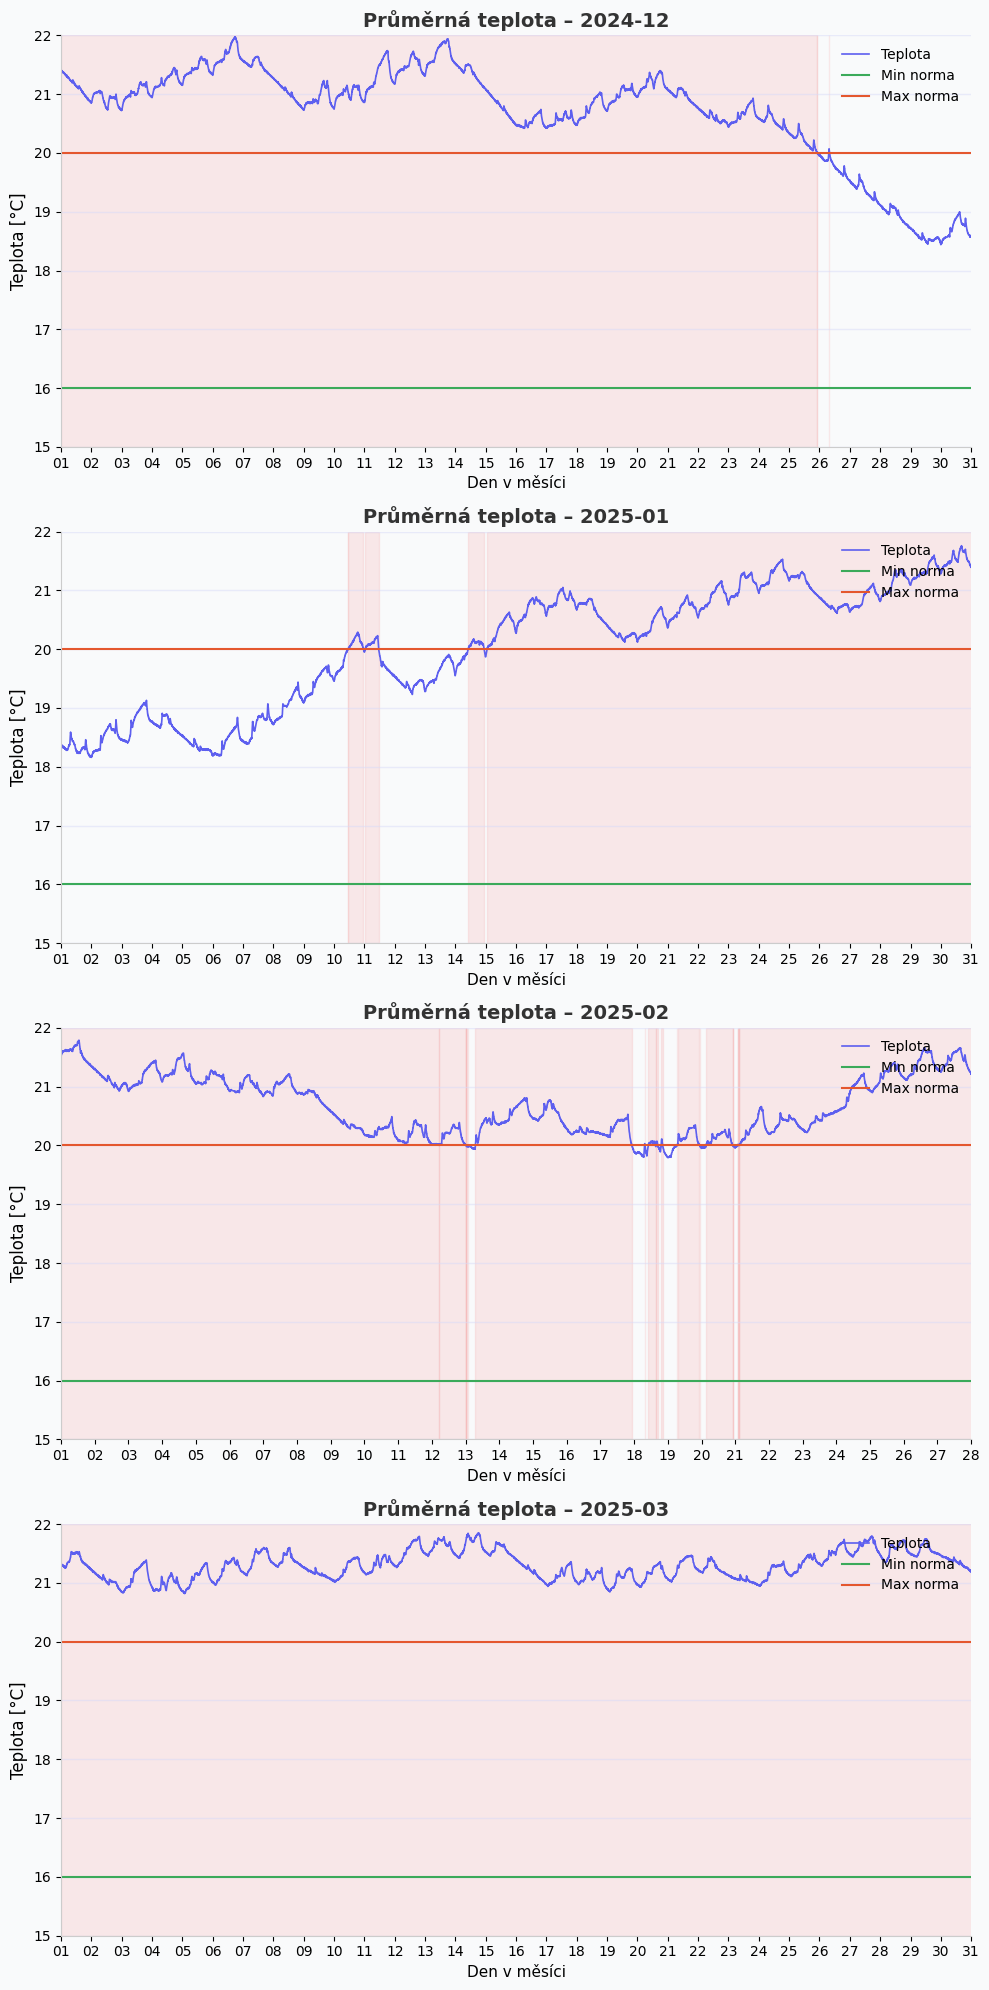

In [8]:
# Přidání měsíce
class_df["Mesic"] = class_df["Datum"].dt.to_period("M")

# Unikátní měsíce
mesice = class_df["Mesic"].sort_values().unique()

# Grafy pod sebou
fig_temp_01, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 20), sharey=True, facecolor=background_color)
axes = axes.flatten()

for i, mesic in enumerate(mesice):
    df_mesic = class_df[class_df["Mesic"] == mesic].copy()

    # Vyhledání překročení limitu
    df_mesic["OverLimit"] = df_mesic["iaq_sensor_temperature_avg"] > max_temp_norm
    df_mesic["UnderLimit"] = df_mesic["iaq_sensor_temperature_avg"] < min_temp_norm
    df_mesic["GroupOver"] = (df_mesic["OverLimit"] != df_mesic["OverLimit"].shift()).cumsum()
    df_mesic["GroupUnder"] = (df_mesic["UnderLimit"] != df_mesic["UnderLimit"].shift()).cumsum()


    ax = axes[i]
    ax.set_facecolor(background_color)

    # Časová řada
    ax.plot(df_mesic["Datum"], df_mesic["iaq_sensor_temperature_avg"],
            label="Teplota", color=line_color, linewidth=1.2)

    # Limity
    ax.axhline(y=min_temp_norm, color=min_line_color, linestyle="-", linewidth=1.5, label="Min norma")
    ax.axhline(y=max_temp_norm, color=max_line_color, linestyle="-", linewidth=1.5, label="Max norma")

 # Zvýraznění překročení
    for _, skupina in df_mesic[df_mesic["OverLimit"]].groupby("GroupOver"):
        start = skupina["Datum"].min()
        end = skupina["Datum"].max()
        ax.axvspan(start, end, color=highlight_above, alpha=0.2)

    for _, skupina in df_mesic[df_mesic["UnderLimit"]].groupby("GroupUnder"):
        start = skupina["Datum"].min()
        end = skupina["Datum"].max()
        ax.axvspan(start, end, color=highlight_below, alpha=0.2)

    # Titulky a osa
    ax.set_title(f"Průměrná teplota – {mesic}", fontsize=14, weight='bold', color="#333333")
    ax.set_ylabel("Teplota [°C]", fontsize=12)
    ax.set_xlabel("Den v měsíci", fontsize=11)
    ax.tick_params(axis='both', labelsize=10)

    # X-axis formát
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d"))

    # Ořez X osy
    mesic_str = str(mesic)
    xmin = pd.to_datetime(f"{mesic_str}-01")
    xmax = xmin + pd.offsets.MonthEnd(0)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim(15, 22)

    # Mřížka a okraje
    ax.grid(axis='y', color=grid_color, linestyle='-', linewidth=1, alpha=0.5)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['bottom'].set_color('#CCCCCC')

    # Legenda
    ax.legend(frameon=False, fontsize=10, loc='upper right')

plt.tight_layout()
plt.show(fig_temp_01)

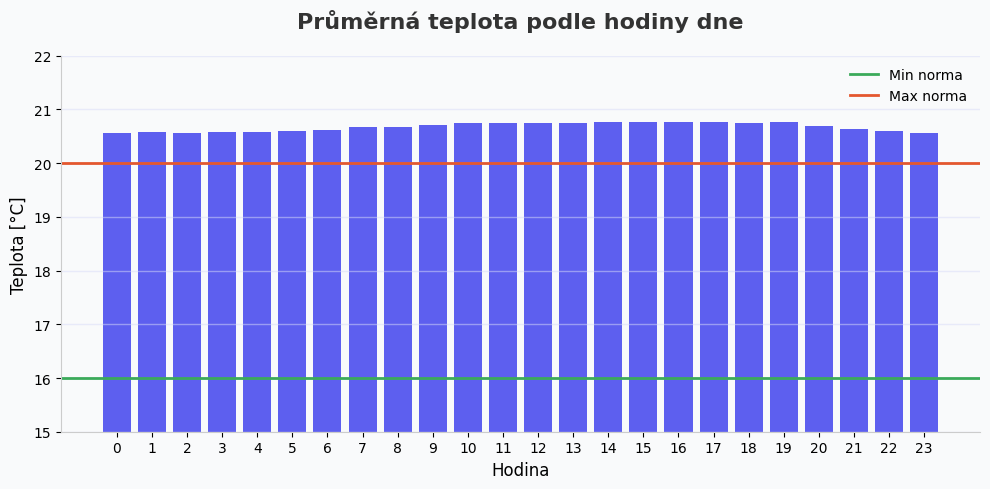

In [9]:
# Přidání hodin (pokud ještě není)
class_df["Hodina"] = class_df["Datum"].dt.hour

# Výpočet průměrné teploty podle hodin
hourly_avg = class_df.groupby("Hodina")["iaq_sensor_temperature_avg"].mean()

# Vykreslení grafu
fig_temp_02, ax = plt.subplots(figsize=(10, 5), facecolor=background_color)
ax.set_facecolor(background_color)

# Sloupce
ax.bar(hourly_avg.index, hourly_avg.values, color=bar_color, edgecolor='none')

# Limity
ax.axhline(y=min_temp_norm, color=min_line_color, linestyle="-", linewidth=2, label="Min norma")
ax.axhline(y=max_temp_norm, color=max_line_color, linestyle="-", linewidth=2, label="Max norma")

# Titulky a osy
ax.set_title("Průměrná teplota podle hodiny dne", fontsize=16, weight='bold', color="#333333", pad=20)
ax.set_xlabel("Hodina", fontsize=12)
ax.set_ylabel("Teplota [°C]", fontsize=12)
ax.set_xticks(range(0, 24))
ax.set_ylim(15, 22)
ax.tick_params(axis='both', labelsize=10)

# Mřížka
ax.grid(axis='y', color=grid_color, linestyle='-', linewidth=1, alpha=0.5)

# Rámečky a stylizace
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['bottom'].set_color('#CCCCCC')

# Legenda
ax.legend(frameon=False, fontsize=10)

plt.tight_layout()
plt.show(fig_temp_02)

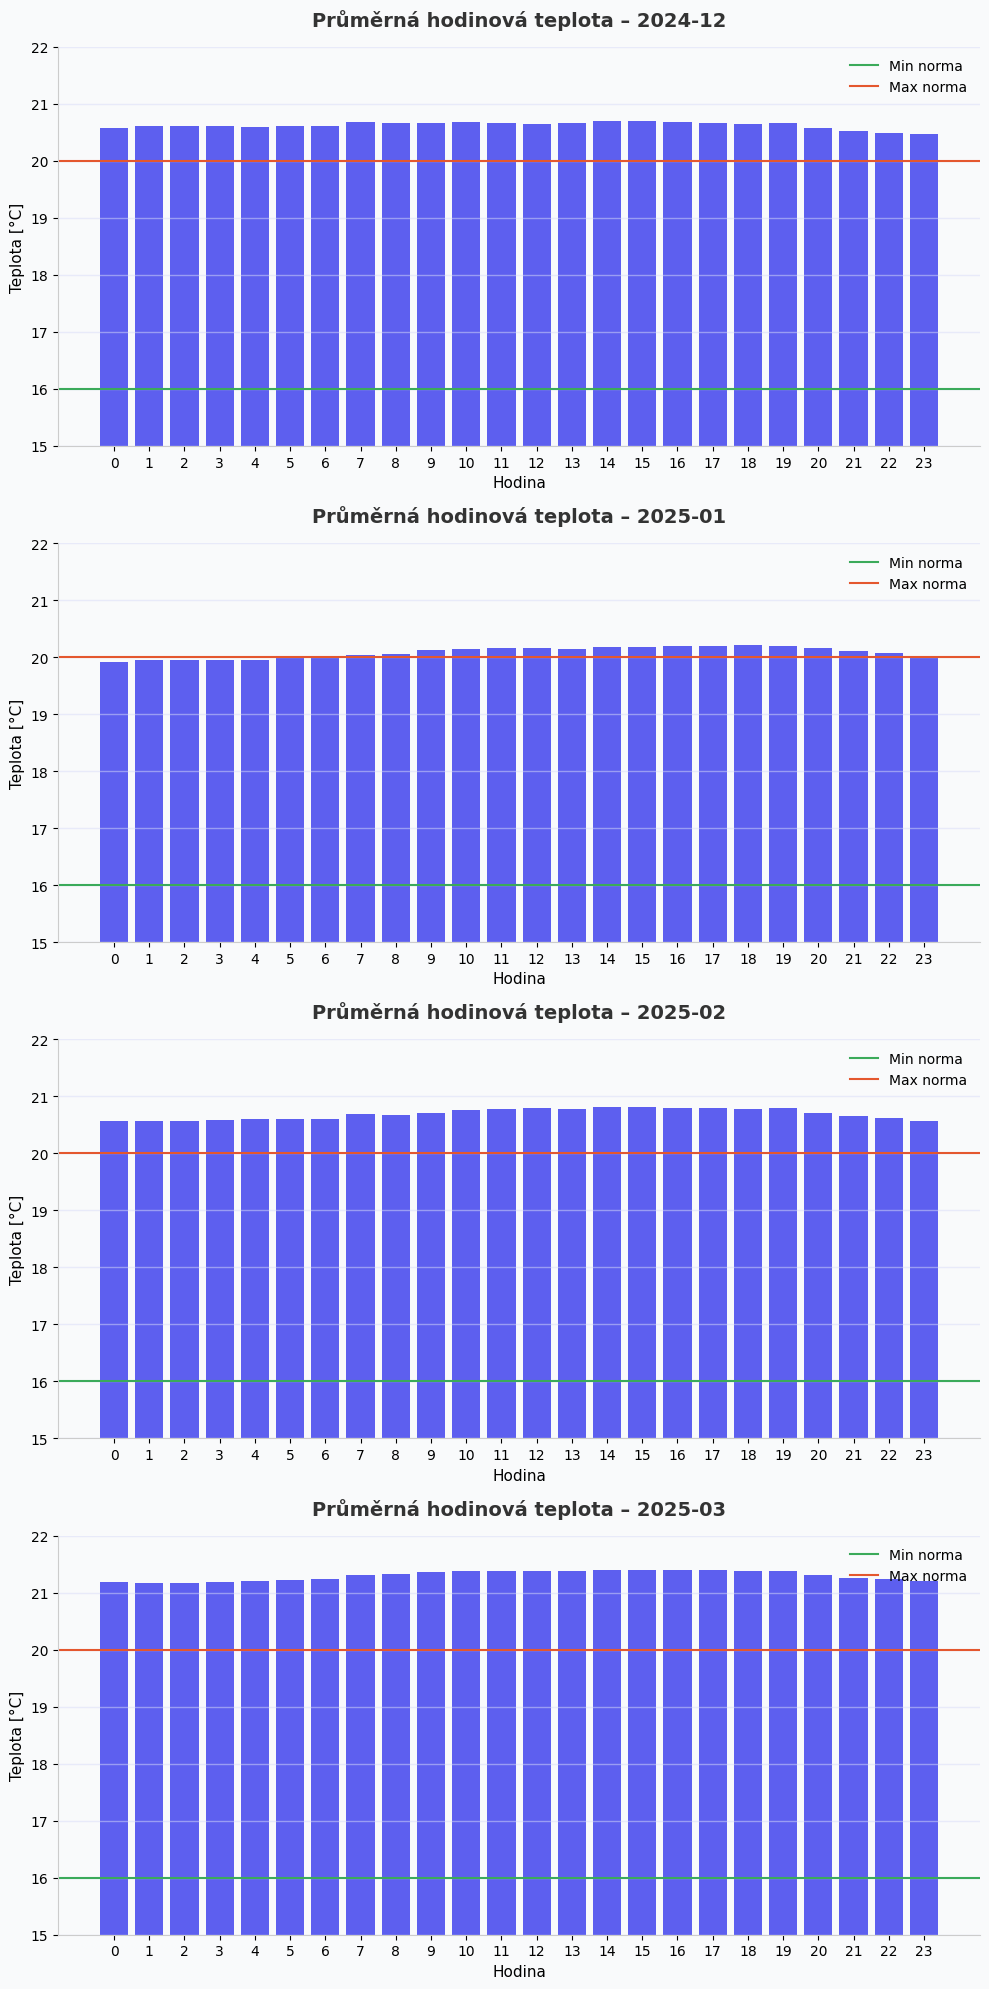

In [10]:
# Přidání měsíce a hodin
class_df["Mesic"] = class_df["Datum"].dt.to_period("M")
class_df["Hodina"] = class_df["Datum"].dt.hour

# Získání unikátních měsíců
mesice = class_df["Mesic"].sort_values().unique()

# Grafy pod sebou
fig_temp_03, axes = plt.subplots(nrows=4, ncols=1, figsize=(10,20), sharey=True, facecolor=background_color)
axes = axes.flatten()

for i, mesic in enumerate(mesice):
    df_mesic = class_df[class_df["Mesic"] == mesic]
    hourly_avg = df_mesic.groupby("Hodina")["iaq_sensor_temperature_avg"].mean()

    ax = axes[i]
    ax.set_facecolor(background_color)

    # Sloupce
    ax.bar(hourly_avg.index, hourly_avg.values, color=bar_color, edgecolor='none')

    # Teplotní normy
    ax.axhline(y=min_temp_norm, color=min_line_color, linestyle="-", linewidth=1.5, label="Min norma")
    ax.axhline(y=max_temp_norm, color=max_line_color, linestyle="-", linewidth=1.5, label="Max norma")

    # Titulky a styl
    ax.set_title(f"Průměrná hodinová teplota – {mesic}", fontsize=14, weight='bold', color="#333333", pad=15)
    ax.set_xlabel("Hodina", fontsize=11)
    ax.set_ylabel("Teplota [°C]", fontsize=11)
    ax.set_xticks(range(0, 24))
    ax.set_ylim(15, 22)
    ax.tick_params(axis='both', labelsize=10)

    # Mřížka
    ax.grid(axis='y', color=grid_color, linestyle='-', linewidth=1, alpha=0.5)

    # Styl os
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['bottom'].set_color('#CCCCCC')

    # Legenda
    ax.legend(frameon=False, fontsize=10, loc="upper right")

plt.tight_layout()
plt.show(fig_temp_03)

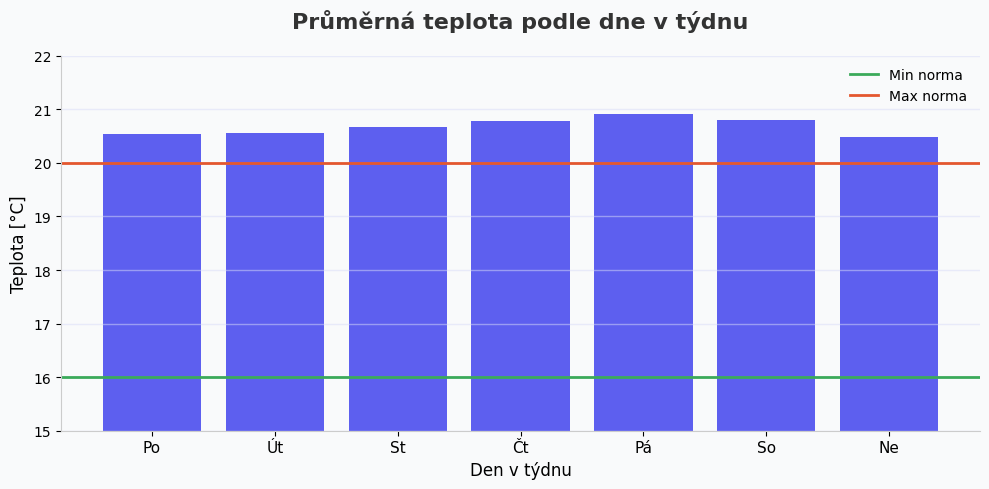

In [11]:
# Přidání dne v týdnu (0 = pondělí)
class_df["DenVTydnu"] = class_df["Datum"].dt.dayofweek

# Názvy dnů
nazvy_dnu = ["Po", "Út", "St", "Čt", "Pá", "So", "Ne"]

# Výpočet průměrné vlhkosti podle dne v týdnu
weekly_avg = class_df.groupby("DenVTydnu")["iaq_sensor_temperature_avg"].mean()

# Vykreslení grafu
fig_temp_04, ax = plt.subplots(figsize=(10, 5), facecolor=background_color)
ax.set_facecolor(background_color)

# Sloupce
ax.bar(weekly_avg.index, weekly_avg.values, color=bar_color, edgecolor='none')

# Limity
ax.axhline(y=min_temp_norm, color=min_line_color, linestyle="-", linewidth=2, label="Min norma")
ax.axhline(y=max_temp_norm, color=max_line_color, linestyle="-", linewidth=2, label="Max norma")

# Titulky a osy
ax.set_title("Průměrná teplota podle dne v týdnu", fontsize=16, weight='bold', color="#333333", pad=20)
ax.set_xlabel("Den v týdnu", fontsize=12)
ax.set_ylabel("Teplota [°C]", fontsize=12)
ax.set_xticks(range(7))
ax.set_xticklabels(nazvy_dnu, fontsize=11)
ax.set_ylim(15, 22)
ax.tick_params(axis='y', labelsize=10)

# Styl os a mřížky
ax.grid(axis='y', color=grid_color, linestyle='-', linewidth=1, alpha=0.5)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['bottom'].set_color('#CCCCCC')

# Legenda
ax.legend(frameon=False, fontsize=10)

plt.tight_layout()
plt.show(fig_temp_04)

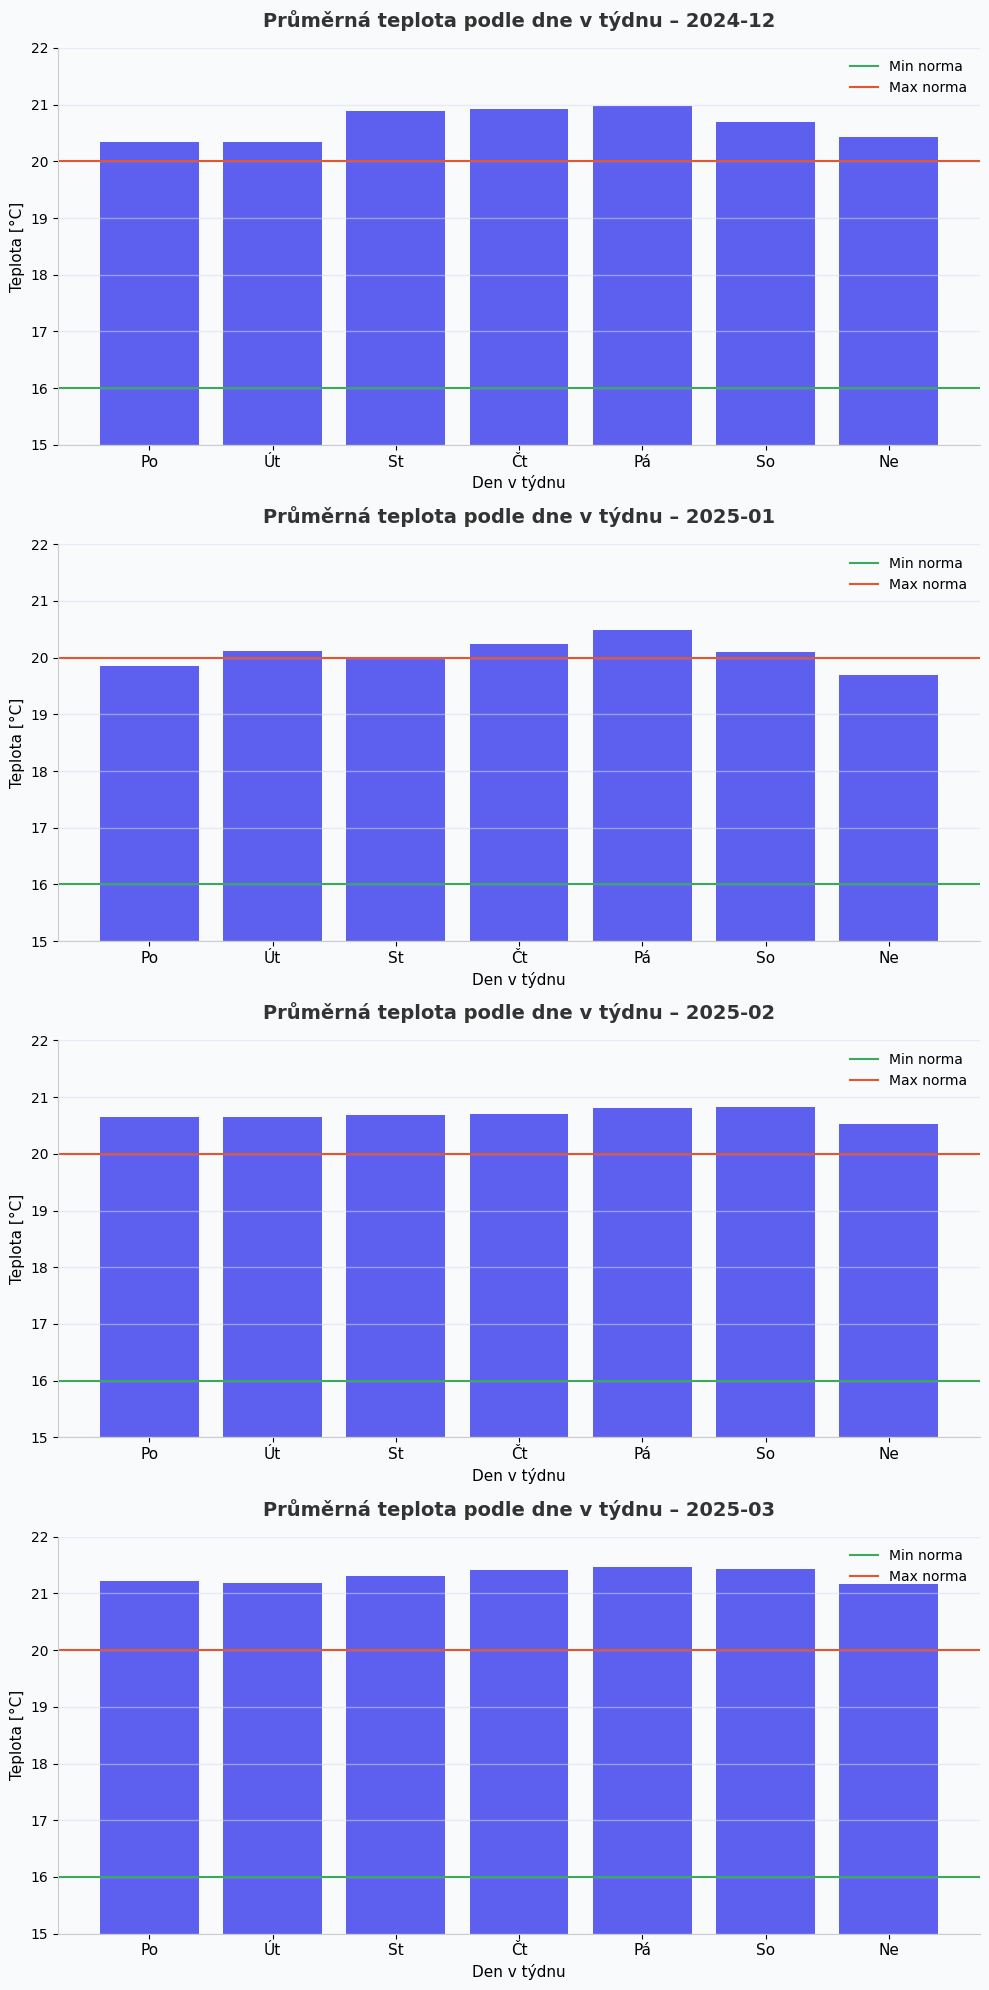

In [12]:
# Přidání měsíce a dne v týdnu
class_df["Mesic"] = class_df["Datum"].dt.to_period("M")
class_df["DenVTydnu"] = class_df["Datum"].dt.dayofweek  # 0 = pondělí

# Názvy dnů v týdnu
nazvy_dnu = ["Po", "Út", "St", "Čt", "Pá", "So", "Ne"]

# Unikátní měsíce
mesice = class_df["Mesic"].sort_values().unique()

# Grafy pod sebou
fig_temp_05, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 20), sharey=True, facecolor=background_color)
axes = axes.flatten()

for i, mesic in enumerate(mesice):
    df_mesic = class_df[class_df["Mesic"] == mesic]
    weekly_avg = df_mesic.groupby("DenVTydnu")["iaq_sensor_temperature_avg"].mean()

    ax = axes[i]
    ax.set_facecolor(background_color)

    # Sloupce
    ax.bar(weekly_avg.index, weekly_avg.values, color=bar_color, edgecolor='none')

    # Limity
    ax.axhline(y=min_temp_norm, color=min_line_color, linestyle="-", linewidth=1.5, label="Min norma")
    ax.axhline(y=max_temp_norm, color=max_line_color, linestyle="-", linewidth=1.5, label="Max norma")

    # Popisky a styly
    ax.set_title(f"Průměrná teplota podle dne v týdnu – {mesic}", fontsize=14, weight='bold', color="#333333", pad=15)
    ax.set_xlabel("Den v týdnu", fontsize=11)
    ax.set_ylabel("Teplota [°C]", fontsize=11)
    ax.set_xticks(range(7))
    ax.set_xticklabels(nazvy_dnu, fontsize=11)
    ax.set_ylim(15, 22)
    ax.tick_params(axis='y', labelsize=10)

    # Styl mřížky a os
    ax.grid(axis='y', color=grid_color, linestyle='-', linewidth=1, alpha=0.5)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['bottom'].set_color('#CCCCCC')

    ax.legend(frameon=False, fontsize=10, loc="upper right")

plt.tight_layout()
plt.show(fig_temp_05)

Vlhkost

In [13]:
class_df[["iaq_sensor_humidity_avg"]].describe().round(3)

,iaq_sensor_humidity_avg
count,34175.000
mean,30.067
std,2.992
min,22.160
25%,27.840
50%,30.020
75%,32.530
max,35.970


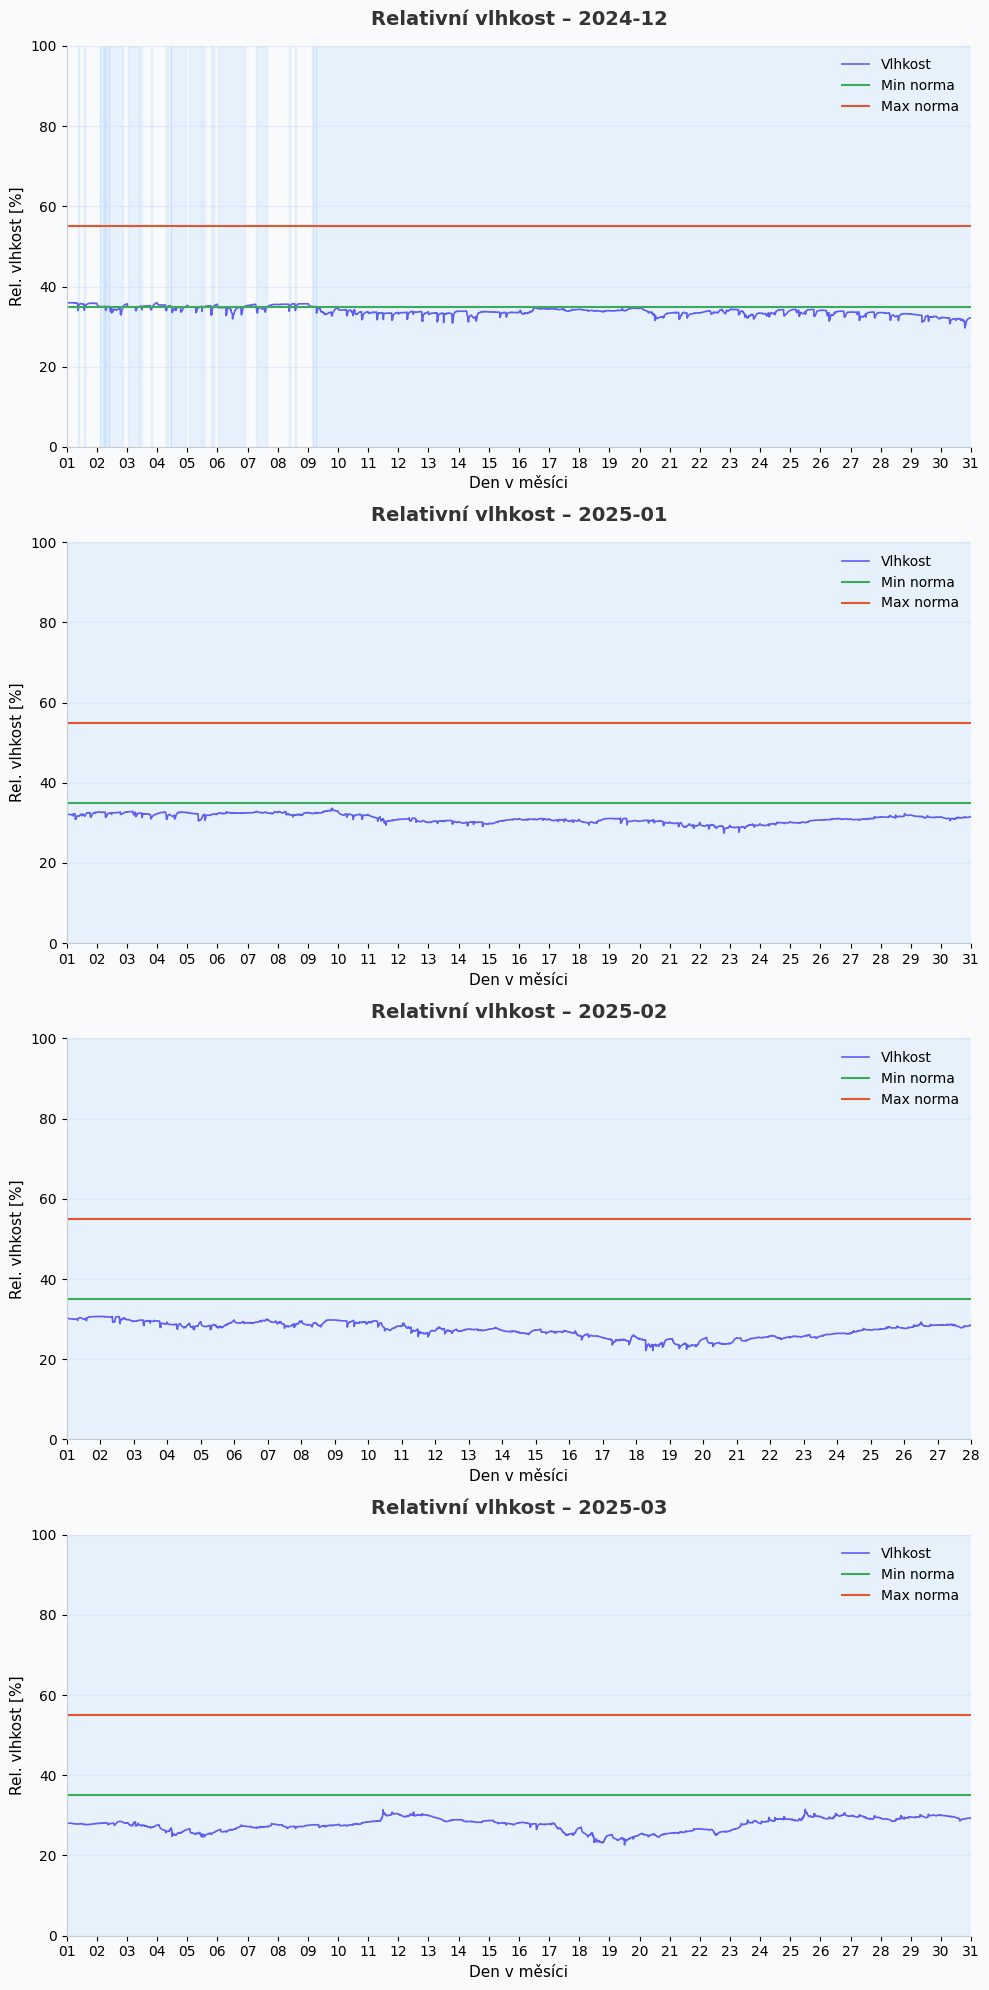

In [14]:
# Přidání měsíce
class_df["Mesic"] = class_df["Datum"].dt.to_period("M")

# Unikátní měsíce
mesice = class_df["Mesic"].sort_values().unique()

# Grafy pod sebou
fig_humi_01, axes = plt.subplots(nrows=4, ncols=1, figsize=(10,20), sharey=True, facecolor=background_color)
axes = axes.flatten()

for i, mesic in enumerate(mesice):
    df_mesic = class_df[class_df["Mesic"] == mesic].copy()

    # Překročení limitů
    df_mesic["OverLimit"] = df_mesic["iaq_sensor_humidity_avg"] > max_hum_norm
    df_mesic["GroupOver"] = (df_mesic["OverLimit"] != df_mesic["OverLimit"].shift()).cumsum()
    df_mesic["UnderLimit"] = df_mesic["iaq_sensor_humidity_avg"] < min_hum_norm
    df_mesic["GroupUnder"] = (df_mesic["UnderLimit"] != df_mesic["UnderLimit"].shift()).cumsum()

    ax = axes[i]
    ax.set_facecolor(background_color)

    # Čára – průběh vlhkosti
    ax.plot(df_mesic["Datum"], df_mesic["iaq_sensor_humidity_avg"],
            label="Vlhkost", color=line_color, linewidth=1.2)

    # Limity
    ax.axhline(y=min_hum_norm, color=min_line_color, linestyle="-", linewidth=1.5, label="Min norma")
    ax.axhline(y=max_hum_norm, color=max_line_color, linestyle="-", linewidth=1.5, label="Max norma")

    # Zvýraznění překročení
    for _, skupina in df_mesic[df_mesic["OverLimit"]].groupby("GroupOver"):
        start = skupina["Datum"].min()
        end = skupina["Datum"].max()
        ax.axvspan(start, end, color=highlight_above, alpha=0.2)

    for _, skupina in df_mesic[df_mesic["UnderLimit"]].groupby("GroupUnder"):
        start = skupina["Datum"].min()
        end = skupina["Datum"].max()
        ax.axvspan(start, end, color=highlight_below, alpha=0.2)

    # Titulky a osy
    ax.set_title(f"Relativní vlhkost – {mesic}", fontsize=14, weight='bold', color="#333333", pad=15)
    ax.set_ylabel("Rel. vlhkost [%]", fontsize=11)
    ax.set_xlabel("Den v měsíci", fontsize=11)
    ax.tick_params(axis='both', labelsize=10)

    # Formát osy X
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d"))

    # Rozsah osy X
    mesic_str = str(mesic)
    xmin = pd.to_datetime(f"{mesic_str}-01")
    xmax = xmin + pd.offsets.MonthEnd(0)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim(0, 100)

    # Styl mřížky a os
    ax.grid(axis='y', color=grid_color, linestyle='-', linewidth=1, alpha=0.5)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['bottom'].set_color('#CCCCCC')

    ax.legend(frameon=False, fontsize=10, loc="upper right")

plt.tight_layout()
plt.show(fig_humi_01)

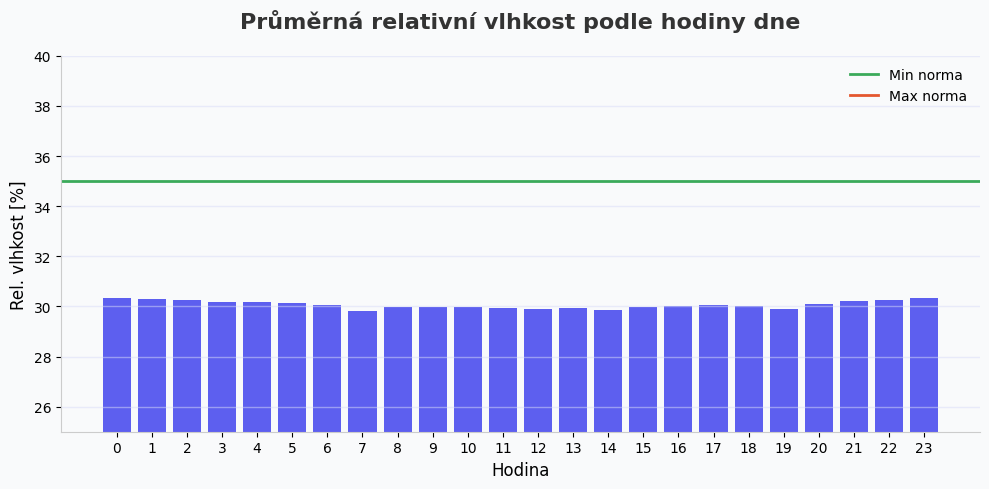

In [15]:
# Výpočet průměrné vlhkosti podle hodin za celé období
hourly_avg = class_df.groupby("Hodina")["iaq_sensor_humidity_avg"].mean()

# Moderní vzhled grafu
fig_humi_02, ax = plt.subplots(figsize=(10, 5), facecolor=background_color)

# Sloupce
bars = ax.bar(hourly_avg.index, hourly_avg.values, color=bar_color, edgecolor='none')

# Vodorovné čáry – limity
plt.axhline(y=min_hum_norm, color=min_line_color, linestyle="-", linewidth=2, label="Min norma")
plt.axhline(y=max_hum_norm, color=max_line_color, linestyle="-", linewidth=2, label="Max norma")

# Titulky a popisky
plt.title("Průměrná relativní vlhkost podle hodiny dne", fontsize=16, weight='bold', color="#333333", pad=20)
plt.xlabel("Hodina", fontsize=12)
plt.ylabel("Rel. vlhkost [%]", fontsize=12)
plt.xticks(range(0, 24), fontsize=10)
plt.yticks(fontsize=10)
plt.ylim(0, 55)

# Styl mřížky
ax.set_facecolor(background_color)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['bottom'].set_color('#CCCCCC')
ax.grid(axis='y', color=grid_color, linestyle='-', linewidth=1, alpha=0.5)
ax.set_ylim(25, 40)
# Legenda
plt.legend(frameon=False, fontsize=10)

plt.tight_layout()
plt.show(fig_humi_02)

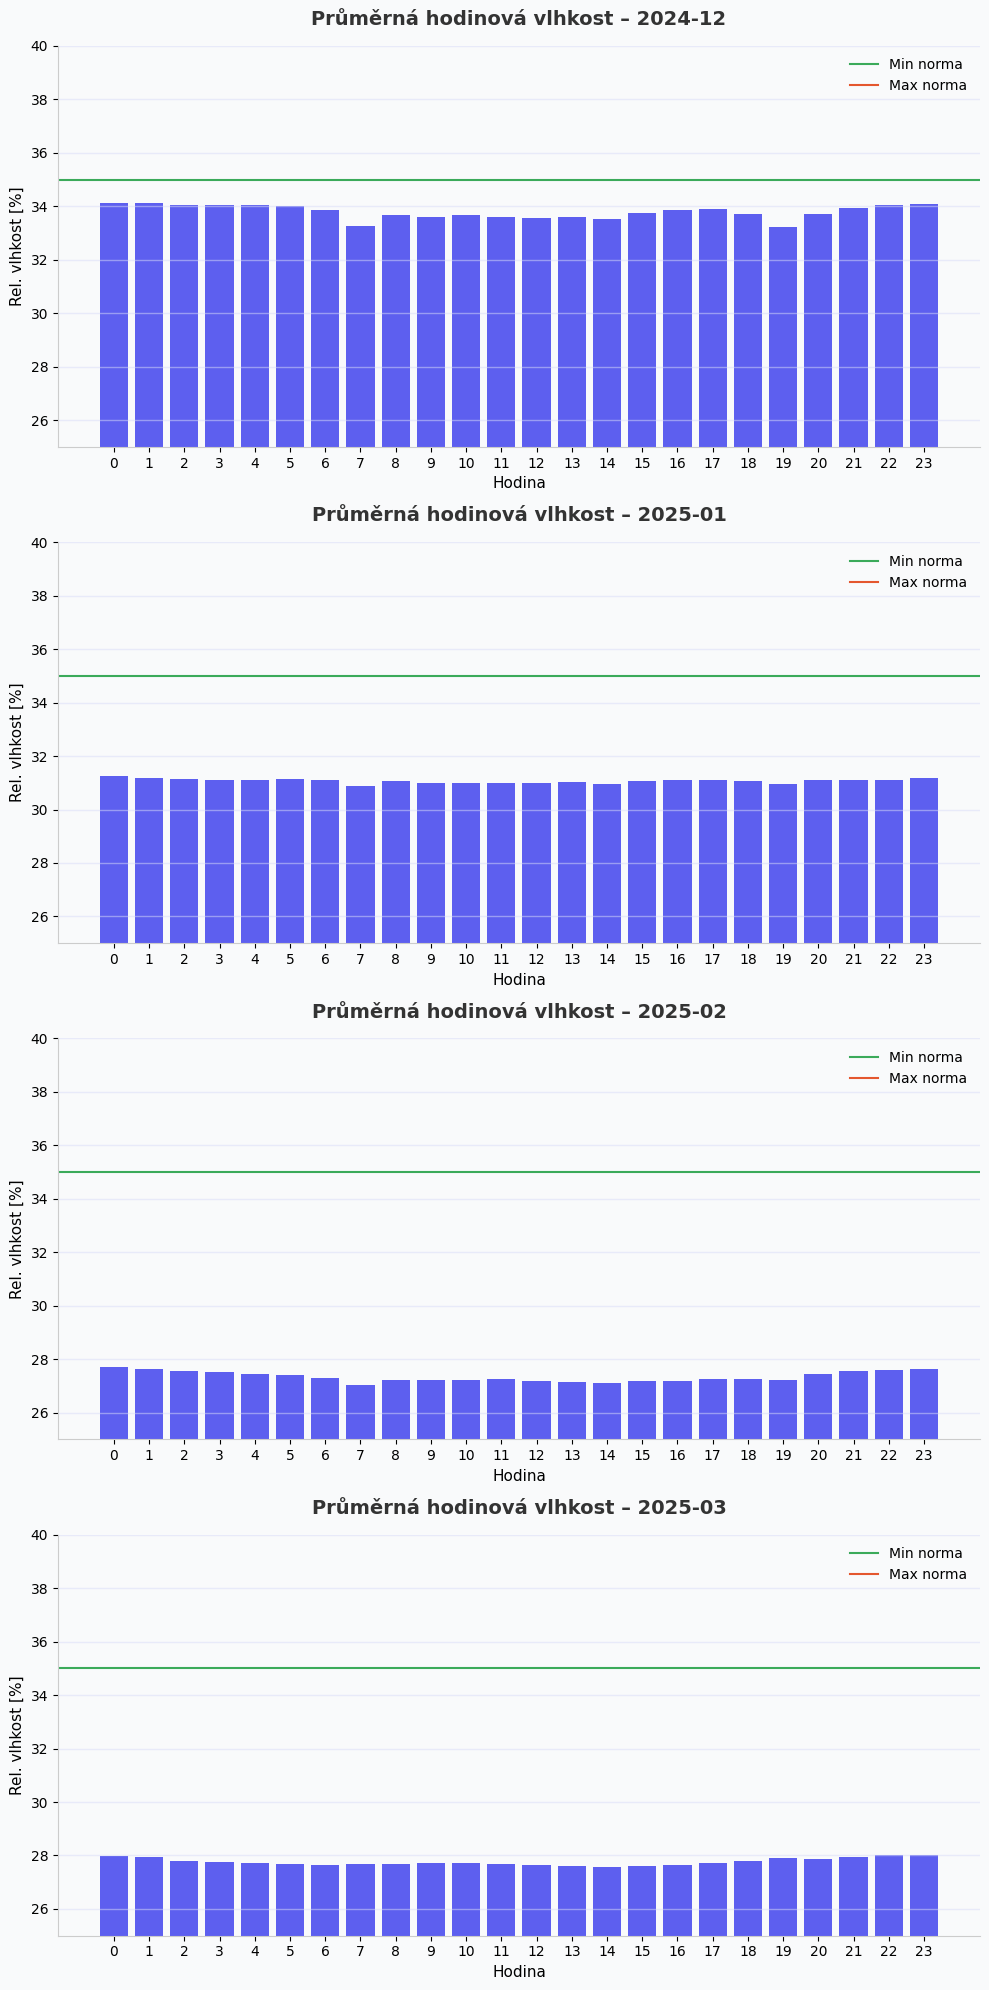

In [16]:
# Přidání měsíce a hodin
class_df["Mesic"] = class_df["Datum"].dt.to_period("M")
class_df["Hodina"] = class_df["Datum"].dt.hour

# Získání unikátních měsíců
mesice = class_df["Mesic"].sort_values().unique()

# Grafy pod sebou
fig_humi_03, axes = plt.subplots(nrows=4, ncols=1, figsize=(10,20), sharey=True, facecolor=background_color)
axes = axes.flatten()

for i, mesic in enumerate(mesice):
    df_mesic = class_df[class_df["Mesic"] == mesic]
    hourly_avg = df_mesic.groupby("Hodina")["iaq_sensor_humidity_avg"].mean()

    ax = axes[i]
    ax.set_facecolor(background_color)

    # Sloupce
    ax.bar(hourly_avg.index, hourly_avg.values, color=bar_color, edgecolor='none')

    # Teplotní normy
    ax.axhline(y=min_hum_norm, color=min_line_color, linestyle="-", linewidth=1.5, label="Min norma")
    ax.axhline(y=max_hum_norm, color=max_line_color, linestyle="-", linewidth=1.5, label="Max norma")

    # Titulky a styl
    ax.set_title(f"Průměrná hodinová vlhkost – {mesic}", fontsize=14, weight='bold', color="#333333", pad=15)
    ax.set_xlabel("Hodina", fontsize=11)
    ax.set_ylabel("Rel. vlhkost [%]", fontsize=11)
    ax.set_xticks(range(0, 24))
    ax.set_ylim(25, 55)
    ax.tick_params(axis='both', labelsize=10)

    # Mřížka
    ax.grid(axis='y', color=grid_color, linestyle='-', linewidth=1, alpha=0.5)

    # Styl os
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['bottom'].set_color('#CCCCCC')
    ax.set_ylim(25, 40)

    # Legenda
    ax.legend(frameon=False, fontsize=10, loc="upper right")

plt.tight_layout()
plt.show(fig_humi_03)


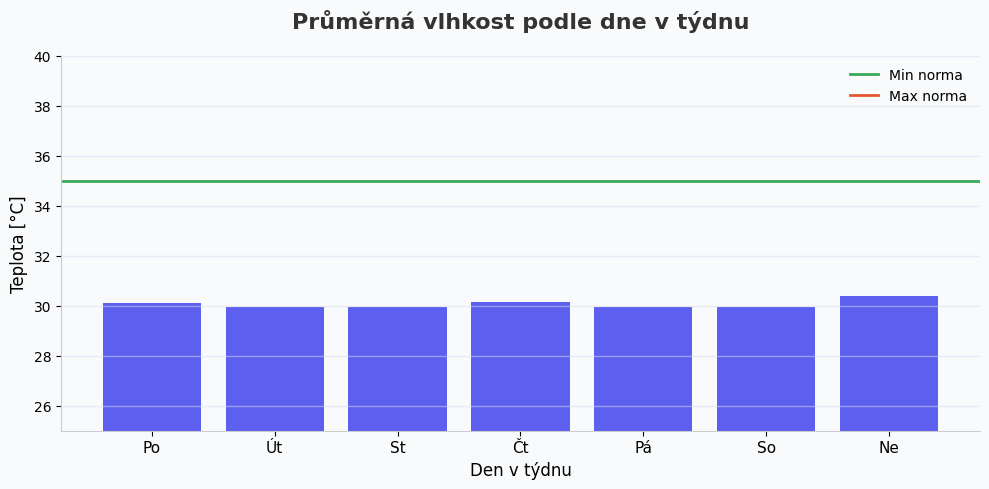

In [17]:
# Přidání dne v týdnu (0 = pondělí)
class_df["DenVTydnu"] = class_df["Datum"].dt.dayofweek

# Názvy dnů
nazvy_dnu = ["Po", "Út", "St", "Čt", "Pá", "So", "Ne"]

# Výpočet průměrné vlhkosti podle dne v týdnu
weekly_avg = class_df.groupby("DenVTydnu")["iaq_sensor_humidity_avg"].mean()

# Vykreslení grafu
fig_humi_04, ax = plt.subplots(figsize=(10, 5), facecolor=background_color)
ax.set_facecolor(background_color)

# Sloupce
ax.bar(weekly_avg.index, weekly_avg.values, color=bar_color, edgecolor='none')

# Limity
ax.axhline(y=min_hum_norm, color=min_line_color, linestyle="-", linewidth=2, label="Min norma")
ax.axhline(y=max_hum_norm, color=max_line_color, linestyle="-", linewidth=2, label="Max norma")

# Titulky a osy
ax.set_title("Průměrná vlhkost podle dne v týdnu", fontsize=16, weight='bold', color="#333333", pad=20)
ax.set_xlabel("Den v týdnu", fontsize=12)
ax.set_ylabel("Teplota [°C]", fontsize=12)
ax.set_xticks(range(7))
ax.set_xticklabels(nazvy_dnu, fontsize=11)
ax.set_ylim(25, 40)
ax.tick_params(axis='y', labelsize=10)

# Styl os a mřížky
ax.grid(axis='y', color=grid_color, linestyle='-', linewidth=1, alpha=0.5)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['bottom'].set_color('#CCCCCC')

# Legenda
ax.legend(frameon=False, fontsize=10)

plt.tight_layout()
plt.show(fig_humi_04)

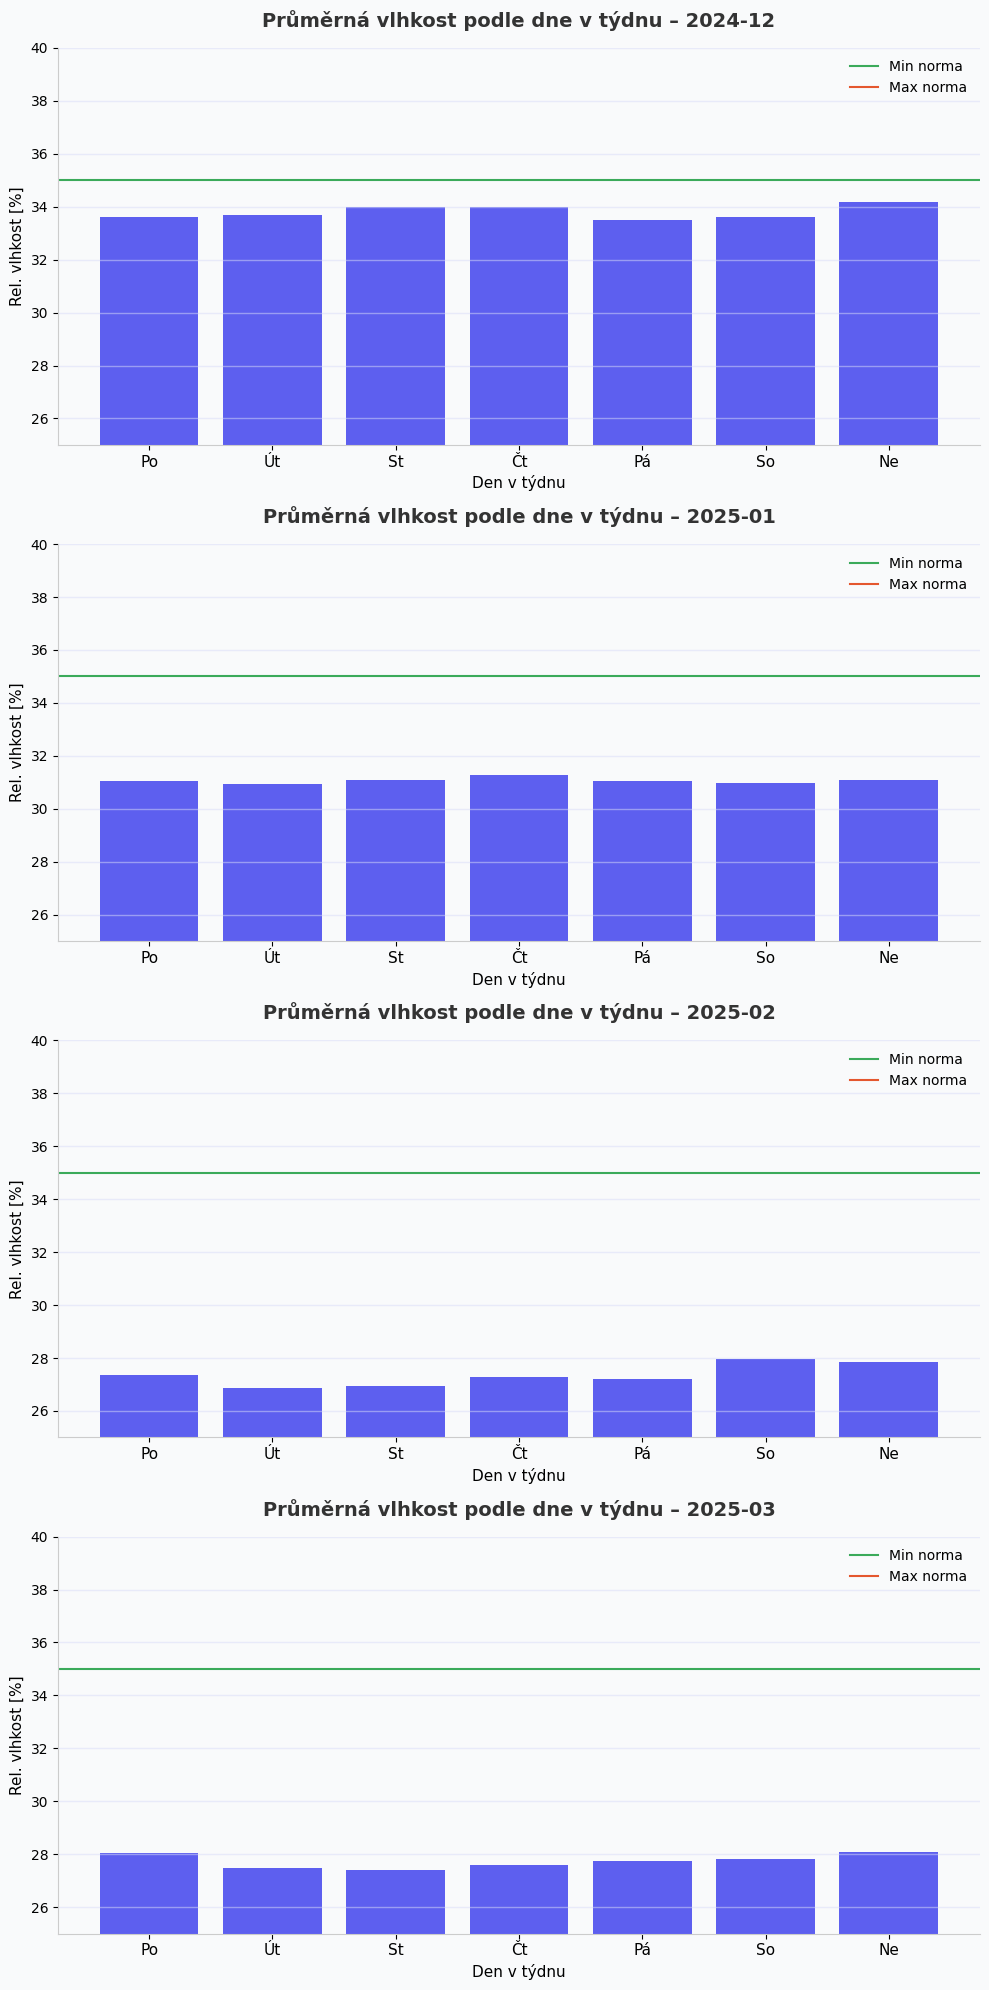

In [18]:
# Přidání měsíce a dne v týdnu
class_df["Mesic"] = class_df["Datum"].dt.to_period("M")
class_df["DenVTydnu"] = class_df["Datum"].dt.dayofweek  # 0 = pondělí

# Názvy dnů v týdnu
nazvy_dnu = ["Po", "Út", "St", "Čt", "Pá", "So", "Ne"]

# Unikátní měsíce
mesice = class_df["Mesic"].sort_values().unique()

# Grafy pod sebou
fig_humi_05, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 20), sharey=True, facecolor=background_color)
axes = axes.flatten()

for i, mesic in enumerate(mesice):
    df_mesic = class_df[class_df["Mesic"] == mesic]
    weekly_avg = df_mesic.groupby("DenVTydnu")["iaq_sensor_humidity_avg"].mean()

    ax = axes[i]
    ax.set_facecolor(background_color)

    # Sloupce
    ax.bar(weekly_avg.index, weekly_avg.values, color=bar_color, edgecolor='none')

    # Limity
    ax.axhline(y=min_hum_norm, color=min_line_color, linestyle="-", linewidth=1.5, label="Min norma")
    ax.axhline(y=max_hum_norm, color=max_line_color, linestyle="-", linewidth=1.5, label="Max norma")

    # Popisky a styly
    ax.set_title(f"Průměrná vlhkost podle dne v týdnu – {mesic}", fontsize=14, weight='bold', color="#333333", pad=15)
    ax.set_xlabel("Den v týdnu", fontsize=11)
    ax.set_ylabel("Rel. vlhkost [%]", fontsize=11)
    ax.set_xticks(range(7))
    ax.set_xticklabels(nazvy_dnu, fontsize=11)
    ax.set_ylim(25, 40)
    ax.tick_params(axis='y', labelsize=10)

    # Styl mřížky a os
    ax.grid(axis='y', color=grid_color, linestyle='-', linewidth=1, alpha=0.5)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['bottom'].set_color('#CCCCCC')

    ax.legend(frameon=False, fontsize=10, loc="upper right")

plt.tight_layout()
plt.show(fig_humi_05)

In [19]:
class_df[["iaq_sensor_illuminance_avg"]].describe().round(3)

,iaq_sensor_illuminance_avg
count,34175.000
mean,13.315
std,25.165
min,0.000
25%,0.000
50%,0.000
75%,4.000
max,120.000


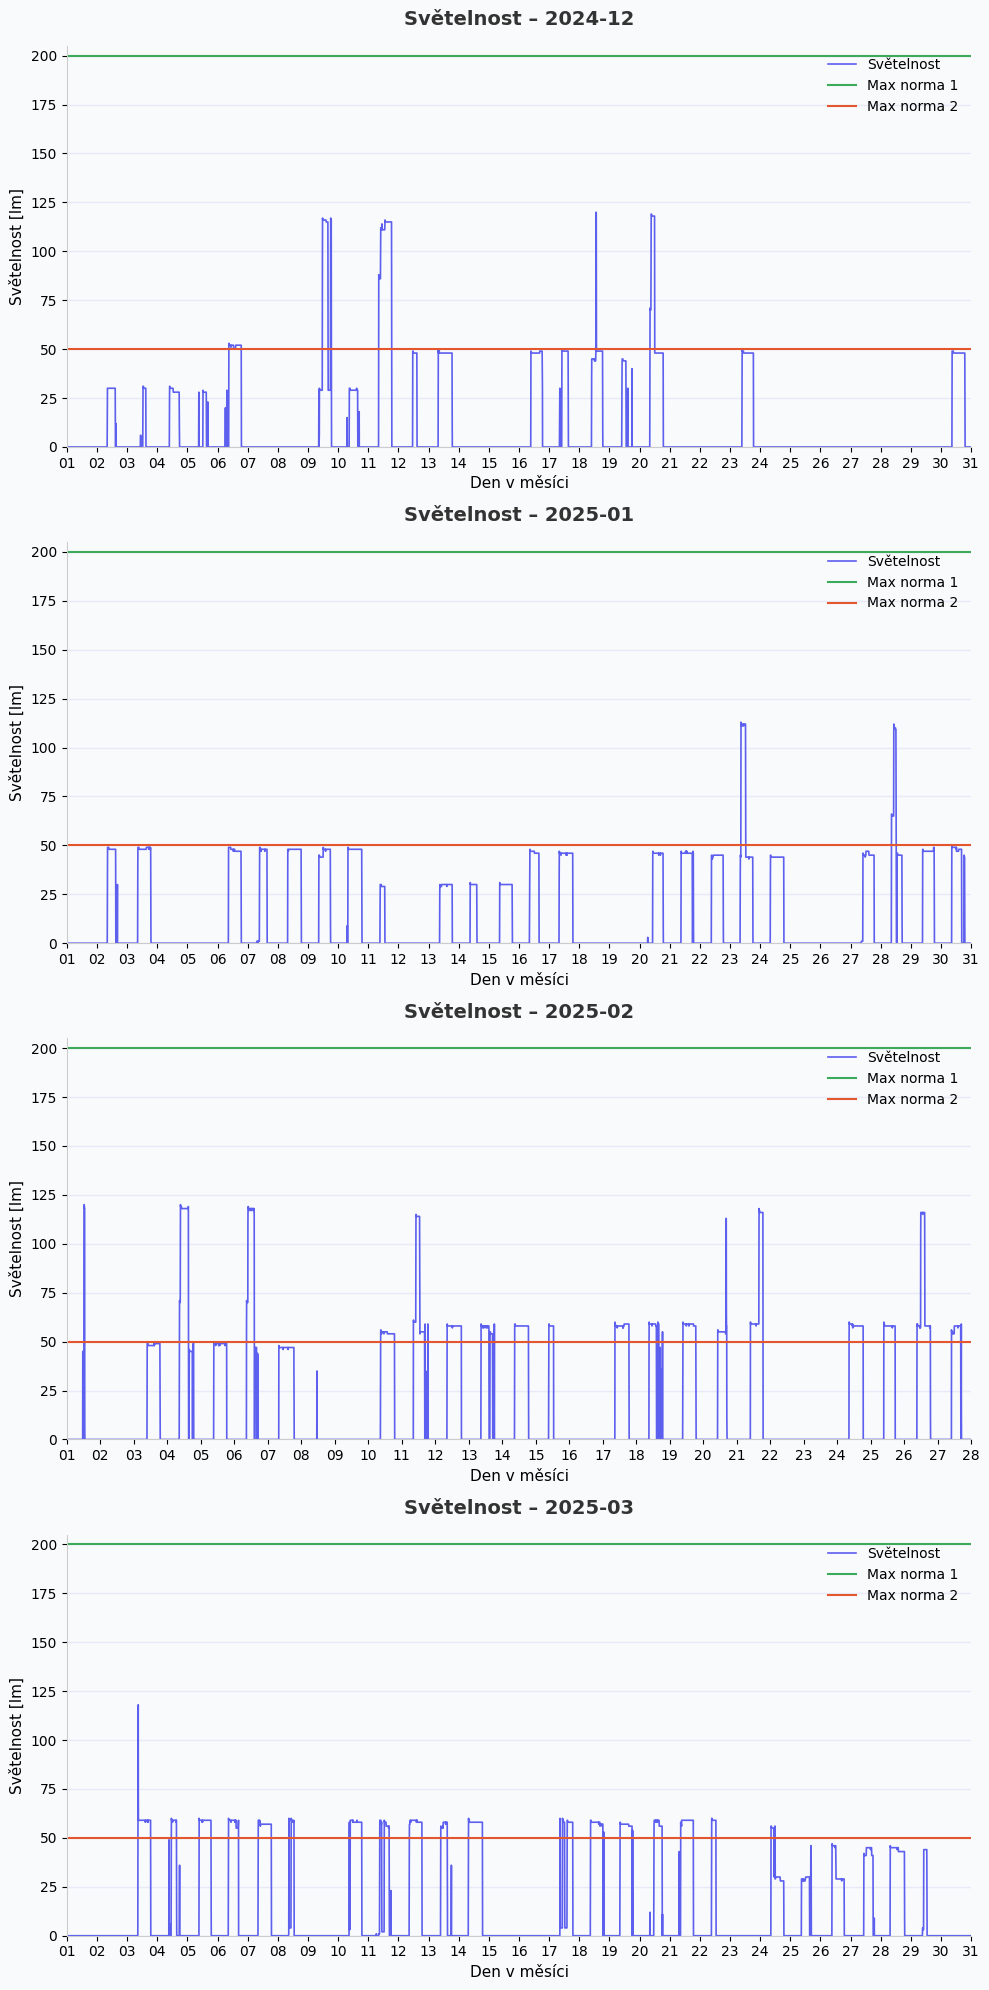

In [20]:
# Přidání měsíce
class_df["Mesic"] = class_df["Datum"].dt.to_period("M")

# Unikátní měsíce
mesice = class_df["Mesic"].sort_values().unique()

# Grafy pod sebou
fig_illu_01, axes = plt.subplots(nrows=4, ncols=1, figsize=(10,20), sharey=True, facecolor=background_color)
axes = axes.flatten()

for i, mesic in enumerate(mesice):
    df_mesic = class_df[class_df["Mesic"] == mesic].copy()

    # Překročení limitů
    df_mesic["OverLimit"] = df_mesic["iaq_sensor_illuminance_avg"] > max_ilum1_norm
    df_mesic["GroupOver"] = (df_mesic["OverLimit"] != df_mesic["OverLimit"].shift()).cumsum()

    ax = axes[i]
    ax.set_facecolor(background_color)

    # Čára – průběh vlhkosti
    ax.plot(df_mesic["Datum"], df_mesic["iaq_sensor_illuminance_avg"],
            label="Světelnost", color=line_color, linewidth=1.2)

    # Limity
    ax.axhline(y=max_ilum1_norm, color=min_line_color, linestyle="-", linewidth=1.5, label="Max norma 1")
    ax.axhline(y=max_ilum2_norm, color=max_line_color, linestyle="-", linewidth=1.5, label="Max norma 2")

    # Zvýraznění překročení
    for _, skupina in df_mesic[df_mesic["OverLimit"]].groupby("GroupOver"):
        start = skupina["Datum"].min()
        end = skupina["Datum"].max()
        ax.axvspan(start, end, color=highlight_above, alpha=0.2)

    # Titulky a osy
    ax.set_title(f"Světelnost – {mesic}", fontsize=14, weight='bold', color="#333333", pad=15)
    ax.set_ylabel("Světelnost [lm]", fontsize=11)
    ax.set_xlabel("Den v měsíci", fontsize=11)
    ax.tick_params(axis='both', labelsize=10)

    # Formát osy X
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d"))

    # Rozsah osy X
    mesic_str = str(mesic)
    xmin = pd.to_datetime(f"{mesic_str}-01")
    xmax = xmin + pd.offsets.MonthEnd(0)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim(0, 205)

    # Styl mřížky a os
    ax.grid(axis='y', color=grid_color, linestyle='-', linewidth=1, alpha=0.5)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['bottom'].set_color('#CCCCCC')

    ax.legend(frameon=False, fontsize=10, loc="upper right")

plt.tight_layout()
plt.show(fig_illu_01)

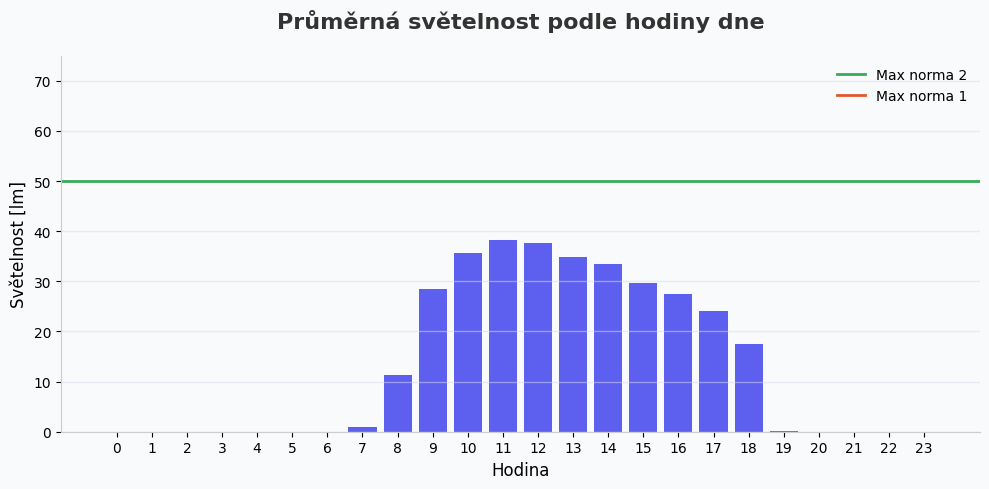

In [21]:
# Přidání hodin (pokud ještě není)
class_df["Hodina"] = class_df["Datum"].dt.hour

# Výpočet průměrné teploty podle hodin
hourly_avg = class_df.groupby("Hodina")["iaq_sensor_illuminance_avg"].mean()

# Vykreslení grafu
fig_illu_02, ax = plt.subplots(figsize=(10, 5), facecolor=background_color)
ax.set_facecolor(background_color)

# Sloupce
ax.bar(hourly_avg.index, hourly_avg.values, color=bar_color, edgecolor='none')

# Limity
ax.axhline(y=max_ilum2_norm, color=min_line_color, linestyle="-", linewidth=2, label="Max norma 2")
ax.axhline(y=max_ilum1_norm, color=max_line_color, linestyle="-", linewidth=2, label="Max norma 1")

# Titulky a osy
ax.set_title("Průměrná světelnost podle hodiny dne", fontsize=16, weight='bold', color="#333333", pad=20)
ax.set_xlabel("Hodina", fontsize=12)
ax.set_ylabel("Světelnost [lm]", fontsize=12)
ax.set_xticks(range(0, 24))
ax.set_ylim(0, 75)
ax.tick_params(axis='both', labelsize=10)

# Mřížka
ax.grid(axis='y', color=grid_color, linestyle='-', linewidth=1, alpha=0.5)

# Rámečky a stylizace
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['bottom'].set_color('#CCCCCC')

# Legenda
ax.legend(frameon=False, fontsize=10)

plt.tight_layout()
plt.show(fig_illu_02)

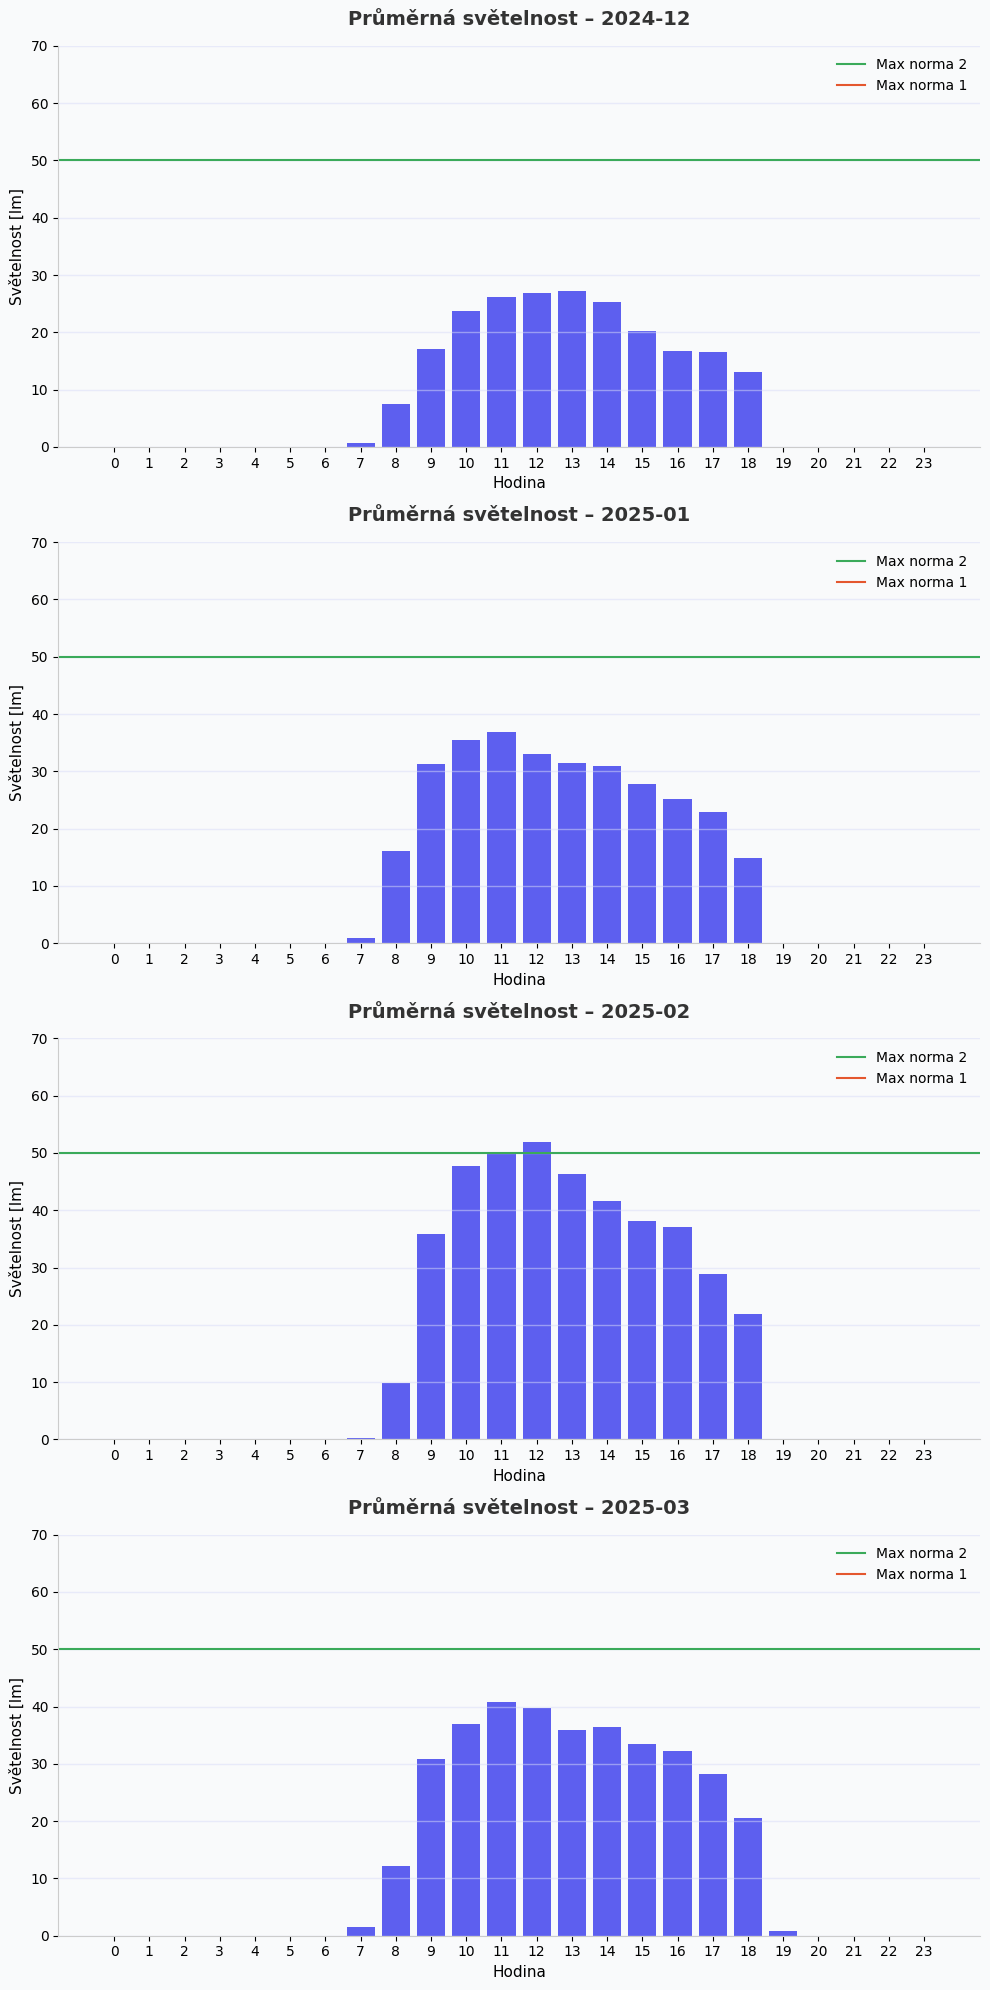

In [22]:
# Přidání měsíce a hodin
class_df["Mesic"] = class_df["Datum"].dt.to_period("M")
class_df["Hodina"] = class_df["Datum"].dt.hour

# Získání unikátních měsíců
mesice = class_df["Mesic"].sort_values().unique()

# Grafy pod sebou
fig_illu_03, axes = plt.subplots(nrows=4, ncols=1, figsize=(10,20), sharey=True, facecolor=background_color)
axes = axes.flatten()

for i, mesic in enumerate(mesice):
    df_mesic = class_df[class_df["Mesic"] == mesic]
    hourly_avg = df_mesic.groupby("Hodina")["iaq_sensor_illuminance_avg"].mean()

    ax = axes[i]
    ax.set_facecolor(background_color)

    # Sloupce
    ax.bar(hourly_avg.index, hourly_avg.values, color=bar_color, edgecolor='none')

    # Teplotní normy
    ax.axhline(y=max_ilum2_norm, color=min_line_color, linestyle="-", linewidth=1.5, label="Max norma 2")
    ax.axhline(y=max_ilum1_norm, color=max_line_color, linestyle="-", linewidth=1.5, label="Max norma 1")

    # Titulky a styl
    ax.set_title(f"Průměrná světelnost – {mesic}", fontsize=14, weight='bold', color="#333333", pad=15)
    ax.set_xlabel("Hodina", fontsize=11)
    ax.set_ylabel("Světelnost [lm]", fontsize=11)
    ax.set_xticks(range(0, 24))
    ax.set_ylim(0, 70)
    ax.tick_params(axis='both', labelsize=10)

    # Mřížka
    ax.grid(axis='y', color=grid_color, linestyle='-', linewidth=1, alpha=0.5)

    # Styl os
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['bottom'].set_color('#CCCCCC')

    # Legenda
    ax.legend(frameon=False, fontsize=10, loc="upper right")

plt.tight_layout()
plt.show(fig_illu_03)

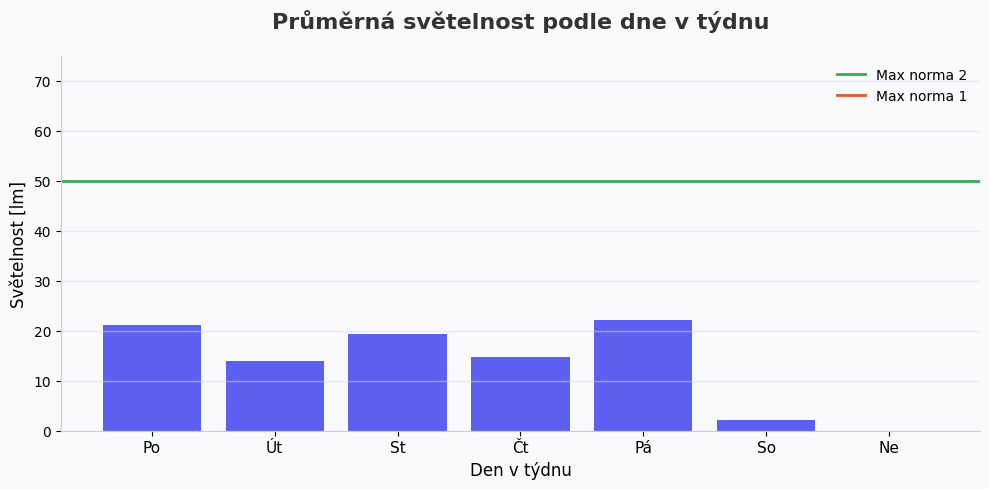

In [23]:
# Přidání dne v týdnu (0 = pondělí)
class_df["DenVTydnu"] = class_df["Datum"].dt.dayofweek

# Názvy dnů
nazvy_dnu = ["Po", "Út", "St", "Čt", "Pá", "So", "Ne"]

# Výpočet průměrné vlhkosti podle dne v týdnu
weekly_avg = class_df.groupby("DenVTydnu")["iaq_sensor_illuminance_avg"].mean()

# Vykreslení grafu
fig_illu_04, ax = plt.subplots(figsize=(10, 5), facecolor=background_color)
ax.set_facecolor(background_color)

# Sloupce
ax.bar(weekly_avg.index, weekly_avg.values, color=bar_color, edgecolor='none')

# Limity
ax.axhline(y=max_ilum2_norm, color=min_line_color, linestyle="-", linewidth=2, label="Max norma 2")
ax.axhline(y=max_ilum1_norm, color=max_line_color, linestyle="-", linewidth=2, label="Max norma 1")

# Titulky a osy
ax.set_title("Průměrná světelnost podle dne v týdnu", fontsize=16, weight='bold', color="#333333", pad=20)
ax.set_xlabel("Den v týdnu", fontsize=12)
ax.set_ylabel("Světelnost [lm]", fontsize=12)
ax.set_xticks(range(7))
ax.set_xticklabels(nazvy_dnu, fontsize=11)
ax.set_ylim(0, 75)
ax.tick_params(axis='y', labelsize=10)

# Styl os a mřížky
ax.grid(axis='y', color=grid_color, linestyle='-', linewidth=1, alpha=0.5)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)
ax.spines['left'].set_color('#CCCCCC')
ax.spines['bottom'].set_color('#CCCCCC')

# Legenda
ax.legend(frameon=False, fontsize=10)

plt.tight_layout()
plt.show(fig_illu_04)

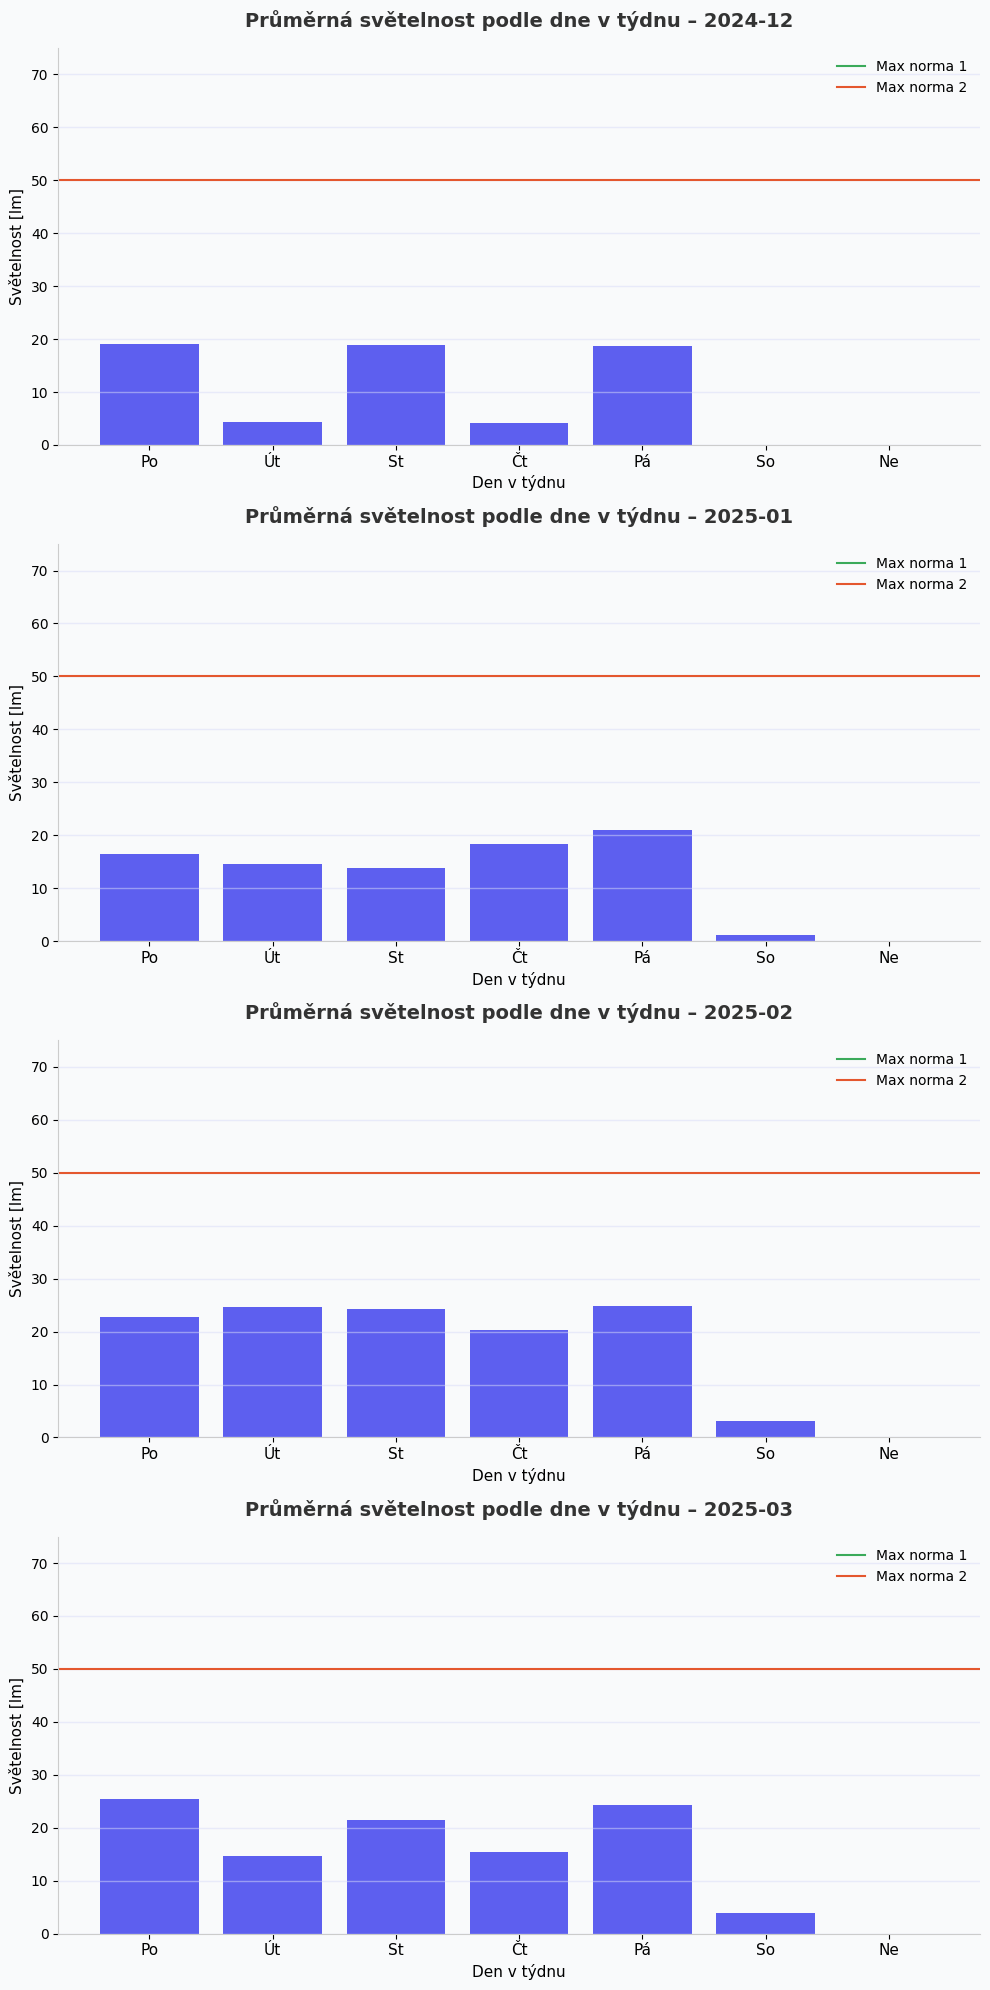

In [24]:
# Přidání měsíce a dne v týdnu
class_df["Mesic"] = class_df["Datum"].dt.to_period("M")
class_df["DenVTydnu"] = class_df["Datum"].dt.dayofweek  # 0 = pondělí

# Názvy dnů v týdnu
nazvy_dnu = ["Po", "Út", "St", "Čt", "Pá", "So", "Ne"]

# Unikátní měsíce
mesice = class_df["Mesic"].sort_values().unique()

# Grafy pod sebou
fig_illu_05, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 20), sharey=True, facecolor=background_color)
axes = axes.flatten()

for i, mesic in enumerate(mesice):
    df_mesic = class_df[class_df["Mesic"] == mesic]
    weekly_avg = df_mesic.groupby("DenVTydnu")["iaq_sensor_illuminance_avg"].mean()

    ax = axes[i]
    ax.set_facecolor(background_color)

    # Sloupce
    ax.bar(weekly_avg.index, weekly_avg.values, color=bar_color, edgecolor='none')

    # Limity
    ax.axhline(y=max_ilum1_norm, color=min_line_color, linestyle="-", linewidth=1.5, label="Max norma 1")
    ax.axhline(y=max_ilum2_norm, color=max_line_color, linestyle="-", linewidth=1.5, label="Max norma 2")

    # Popisky a styly
    ax.set_title(f"Průměrná světelnost podle dne v týdnu – {mesic}", fontsize=14, weight='bold', color="#333333", pad=15)
    ax.set_xlabel("Den v týdnu", fontsize=11)
    ax.set_ylabel("Světelnost [lm]", fontsize=11)
    ax.set_xticks(range(7))
    ax.set_xticklabels(nazvy_dnu, fontsize=11)
    ax.set_ylim(0, 75)
    ax.tick_params(axis='y', labelsize=10)

    # Styl mřížky a os
    ax.grid(axis='y', color=grid_color, linestyle='-', linewidth=1, alpha=0.5)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['bottom'].set_color('#CCCCCC')

    ax.legend(frameon=False, fontsize=10, loc="upper right")

plt.tight_layout()
plt.show(fig_illu_05)

In [25]:
class_df[["iaq_sensor_pressure_avg"]].describe().round(3)

,iaq_sensor_pressure_avg
count,34175.000
mean,97573.191
std,998.550
min,95014.000
25%,96892.000
50%,97689.000
75%,98359.000
max,99702.000


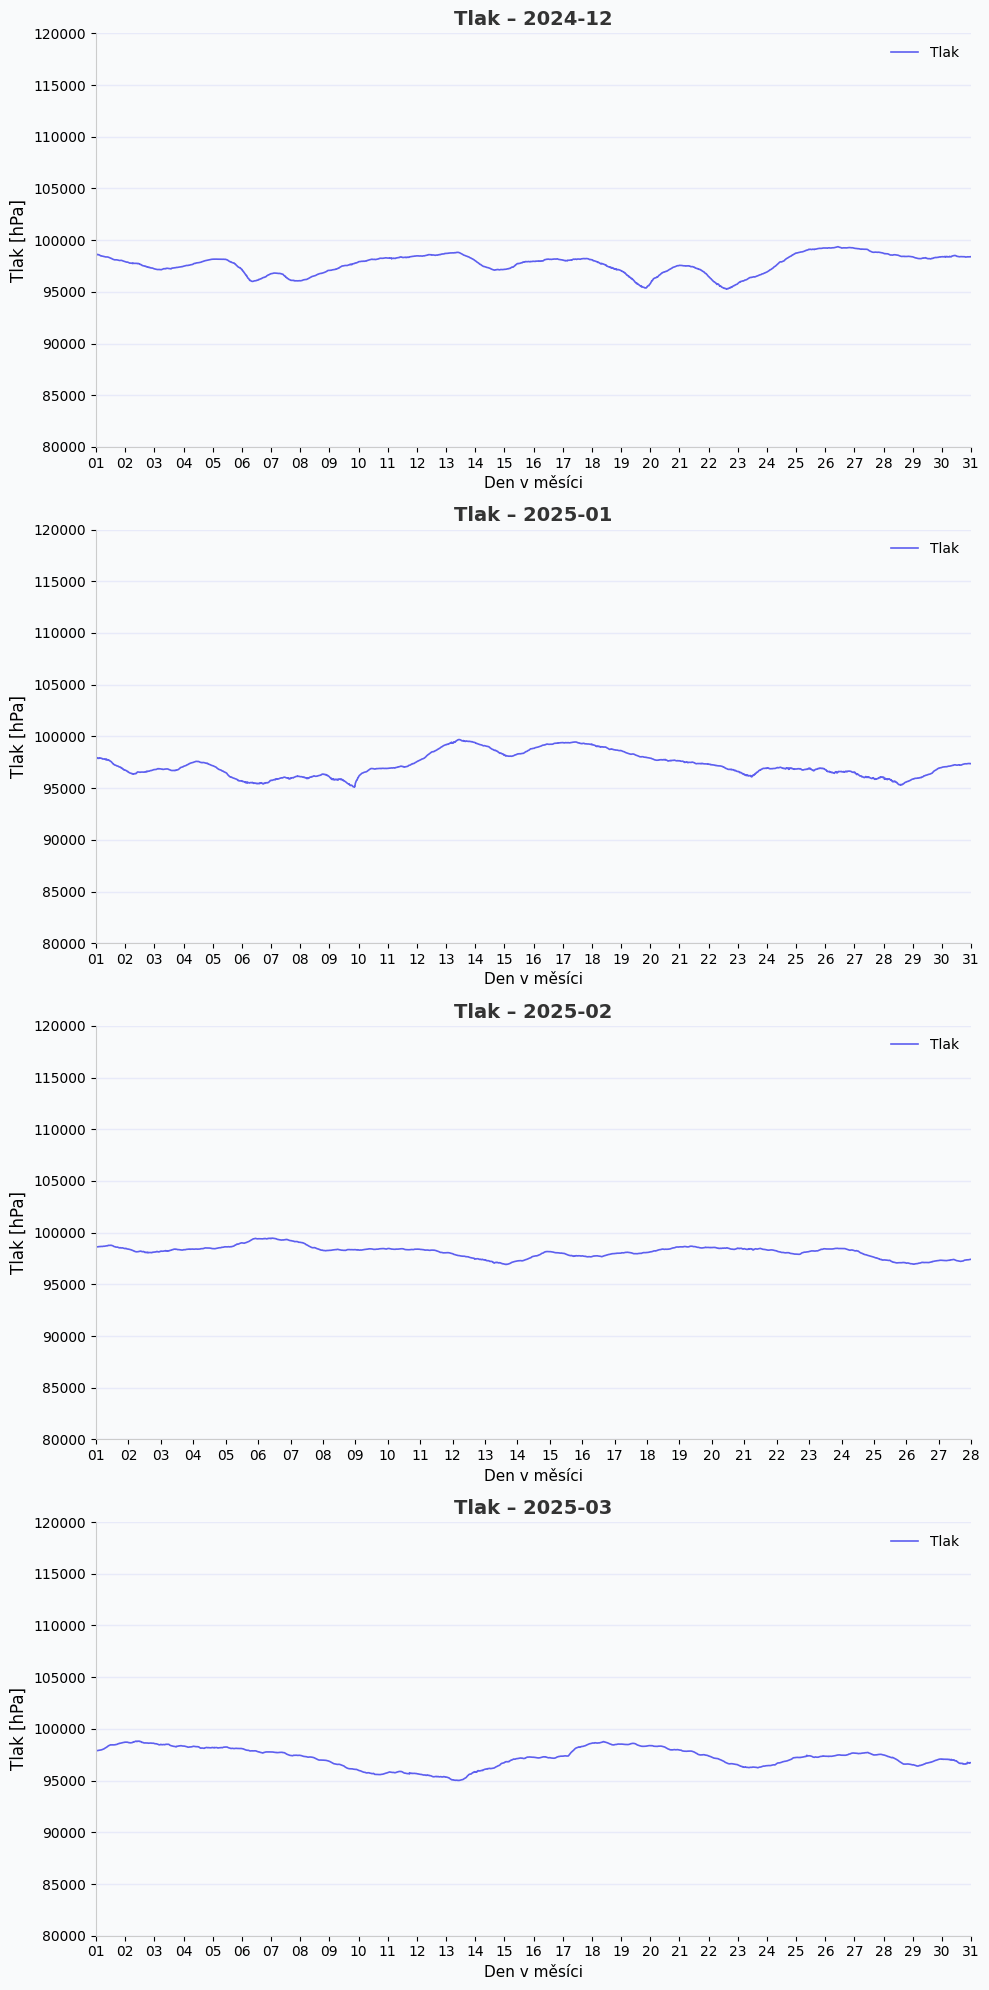

In [26]:
# Přidání měsíce
class_df["Mesic"] = class_df["Datum"].dt.to_period("M")

# Unikátní měsíce
mesice = class_df["Mesic"].sort_values().unique()

# Grafy pod sebou
fig_press_01, axes = plt.subplots(nrows=4, ncols=1, figsize=(10, 20), sharey=True, facecolor=background_color)
axes = axes.flatten()

for i, mesic in enumerate(mesice):
    df_mesic = class_df[class_df["Mesic"] == mesic].copy()

    ax = axes[i]
    ax.set_facecolor(background_color)

    # Časová řada
    ax.plot(df_mesic["Datum"], df_mesic["iaq_sensor_pressure_avg"],
            label="Tlak", color=line_color, linewidth=1.2)

    # Titulky a osa
    ax.set_title(f"Tlak – {mesic}", fontsize=14, weight='bold', color="#333333")
    ax.set_ylabel("Tlak [hPa]", fontsize=12)
    ax.set_xlabel("Den v měsíci", fontsize=11)
    ax.tick_params(axis='both', labelsize=10)

    # X-axis formát
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d"))

    # Ořez X osy
    mesic_str = str(mesic)
    xmin = pd.to_datetime(f"{mesic_str}-01")
    xmax = xmin + pd.offsets.MonthEnd(0)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim(80000, 120000)

    # Mřížka a okraje
    ax.grid(axis='y', color=grid_color, linestyle='-', linewidth=1, alpha=0.5)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['bottom'].set_color('#CCCCCC')

    # Legenda
    ax.legend(frameon=False, fontsize=10, loc='upper right')

plt.tight_layout()
plt.show(fig_press_01)

In [27]:
class_df[["iaq_sensor_co2_conc_avg"]].describe().round(3)

,iaq_sensor_co2_conc_avg
count,34175.000
mean,416.612
std,17.636
min,379.000
25%,403.000
50%,415.000
75%,429.000
max,502.000


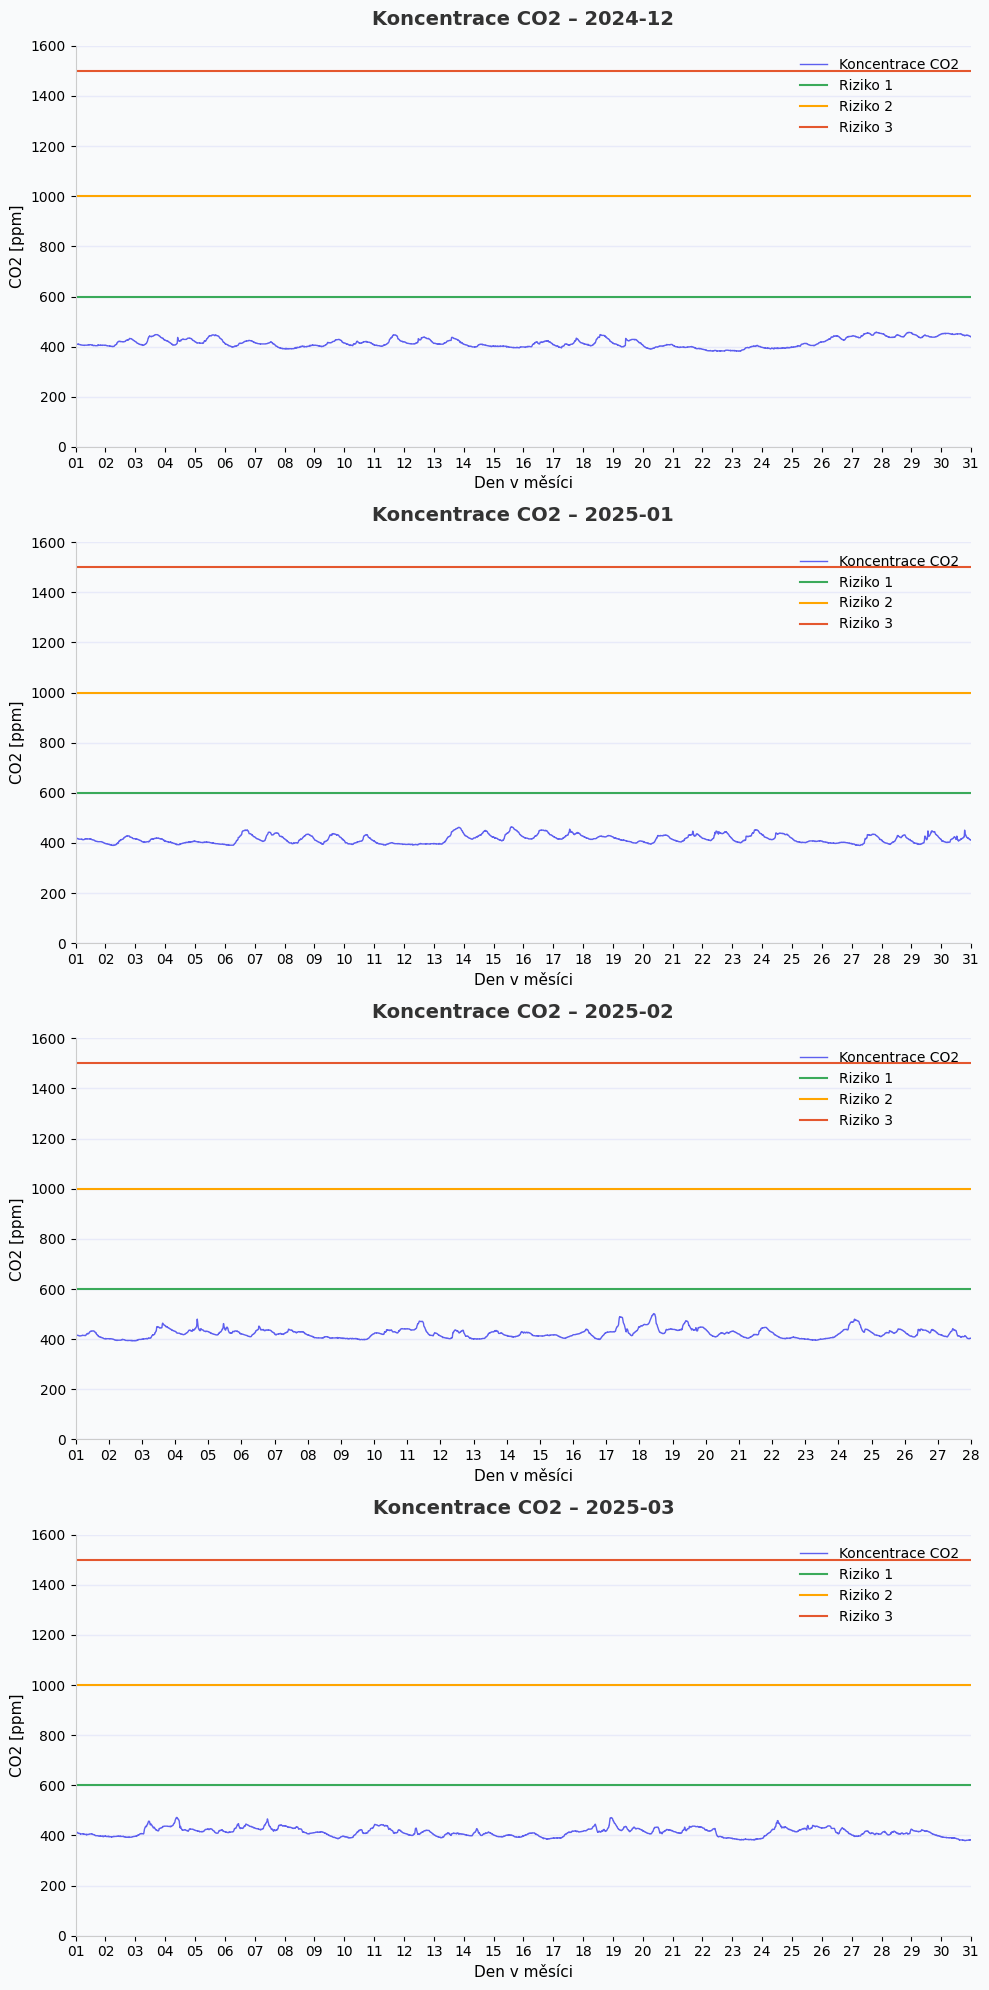

In [28]:
# Přidání měsíce
class_df["Mesic"] = class_df["Datum"].dt.to_period("M")

# Unikátní měsíce
mesice = class_df["Mesic"].sort_values().unique()

# Grafy pod sebou
fig_co2_01, axes = plt.subplots(nrows=4, ncols=1, figsize=(10,20), sharey=True, facecolor=background_color)
axes = axes.flatten()

for i, mesic in enumerate(mesice):
    df_mesic = class_df[class_df["Mesic"] == mesic].copy()

    ax = axes[i]
    ax.set_facecolor(background_color)

    # Čára – průběh vlhkosti
    ax.plot(df_mesic["Datum"], df_mesic["iaq_sensor_co2_conc_avg"],
            label="Koncentrace CO2", color=line_color, linewidth=1)

    # Limity
    ax.axhline(y=co21, color=min_line_color, linestyle="-", linewidth=1.5, label="Riziko 1")
    ax.axhline(y=co22, color="orange", linestyle="-", linewidth=1.5, label="Riziko 2")
    ax.axhline(y=co23, color=max_line_color, linestyle="-", linewidth=1.5, label="Riziko 3")

    # Titulky a osy
    ax.set_title(f"Koncentrace CO2 – {mesic}", fontsize=14, weight='bold', color="#333333", pad=15)
    ax.set_ylabel("CO2 [ppm]", fontsize=11)
    ax.set_xlabel("Den v měsíci", fontsize=11)
    ax.tick_params(axis='both', labelsize=10)

    # Formát osy X
    ax.xaxis.set_major_locator(mdates.DayLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%d"))

    # Rozsah osy X
    mesic_str = str(mesic)
    xmin = pd.to_datetime(f"{mesic_str}-01")
    xmax = xmin + pd.offsets.MonthEnd(0)
    ax.set_xlim([xmin, xmax])
    ax.set_ylim(0, 1600)

    # Styl mřížky a os
    ax.grid(axis='y', color=grid_color, linestyle='-', linewidth=1, alpha=0.5)
    for spine in ['top', 'right']:
        ax.spines[spine].set_visible(False)
    ax.spines['left'].set_color('#CCCCCC')
    ax.spines['bottom'].set_color('#CCCCCC')

    ax.legend(frameon=False, fontsize=10, loc="upper right")

plt.tight_layout()
plt.show(fig_co2_01)

In [29]:
# Stažení grafů do složky
import os

output_dir = "2_trida_grafy"
os.makedirs(output_dir, exist_ok=True)

# Slovník: jméno souboru -> figure object
grafy = {
    "temp_01.png" : fig_temp_01,
    "temp_02.png" : fig_temp_02,
    "temp_03.png" : fig_temp_03,
    "temp_04.png" : fig_temp_04,
    "temp_05.png" : fig_temp_05,

    "humi_01.png" : fig_humi_01,
    "humi_02.png" : fig_humi_02,
    "humi_03.png" : fig_humi_03,
    "humi_04.png" : fig_humi_04,
    "humi_05.png" : fig_humi_05,

    "illu_01.png" : fig_illu_01,
    "illu_02.png" : fig_illu_02,
    "illu_03.png" : fig_illu_03,
    "illu_04.png" : fig_illu_04,
    "illu_05.png" : fig_illu_05,

    "press_01.png": fig_press_01,

    "co2_01.png": fig_co2_01
}

for name, fig in grafy.items():
    fig.savefig(os.path.join(output_dir, name), dpi=200)